# **Data Exploration**

**Mục tiêu**:

- Hiểu cấu trúc dữ liệu: số dòng, số cột, danh sách và ý nghĩa các features.
- Đánh giá chất lượng dữ liệu: missing, invalid, cardinality, outliers.
- Phân tích phân phối của từng feature (numeric & categorical).
- Phân tích mối quan hệ giữa feature với nhau và với biến mục tiêu `target`.
- Rút ra các insight, đặt và trả lời một số câu hỏi để hiểu sâu cũng như các fun fact về bộ dữ liệu.

## Import thư viện & module trong src

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.visualization import (
    plot_missing_bar,
    plot_outliers,
    plot_target_distribution,
    plot_numeric_distribution,
    plot_ecdf,
    plot_categorical_distribution,
    plot_pie,
    plot_target_rate_by_category,
    boxplot_numeric_by_target,
    plot_hist_overlay_by_target,
    visualize_q1_risk_profiles,
    visualize_q2_churn_last_new_job_by_company_type,
    visualize_q3_training_hours_by_experience_groups,
    visualize_q4_leave_city,
    visualize_q5_enrollment_experience_interaction
)

# Để phục vụ phân tích thông kê và trả lời các câu hỏi insight
from src.data_processing import (
    string_column_to_float,
    detect_outliers_iqr,
    EXPERIENCE_ORDER,
    LAST_NEW_JOB_ORDER,
    ordinal_encode,
)

# Để xem số liệu rõ ràng hơn
np.set_printoptions(suppress=True)

## I. Chuẩn bị dữ liệu & Thông tin tổng quan

**Ở phần này sẽ thực hiện các công việc sau:**

- Load file CSV vào NumPy.
- Tách header và data.
- In ra số dòng, số cột.
- Liệt kê danh sách các feature.

### Load dữ liệu

In [2]:
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "raw", "aug_train.csv")

with open(DATA_PATH, "r", encoding="utf-8") as f:
    header = f.readline().strip().split(",")

data = np.genfromtxt(
    DATA_PATH,
    delimiter=",",
    dtype=str,
    skip_header=1
)

print("Xem thử 5 dòng đầu của bộ dữ liệu:")
for i in range(5):
    print(data[i])

Xem thử 5 dòng đầu của bộ dữ liệu:
['8949' 'city_103' '0.92' 'Male' 'Has relevent experience' 'no_enrollment'
 'Graduate' 'STEM' '>20' '' '' '1' '36' '1.0']
['29725' 'city_40' '0.7759999999999999' 'Male' 'No relevent experience'
 'no_enrollment' 'Graduate' 'STEM' '15' '50-99' 'Pvt Ltd' '>4' '47' '0.0']
['11561' 'city_21' '0.624' '' 'No relevent experience' 'Full time course'
 'Graduate' 'STEM' '5' '' '' 'never' '83' '0.0']
['33241' 'city_115' '0.789' '' 'No relevent experience' '' 'Graduate'
 'Business Degree' '<1' '' 'Pvt Ltd' 'never' '52' '1.0']
['666' 'city_162' '0.767' 'Male' 'Has relevent experience' 'no_enrollment'
 'Masters' 'STEM' '>20' '50-99' 'Funded Startup' '4' '8' '0.0']


### Thông tin tổng quan

In [3]:
num_rows, num_cols = data.shape

print(f"Số dòng (samples): {num_rows}")
print(f"Số cột (features): {num_cols}\n")

print("Danh sách features:")
for i, col in enumerate(header):
    print(f"{i:2d}. {col}")

Số dòng (samples): 19158
Số cột (features): 14

Danh sách features:
 0. enrollee_id
 1. city
 2. city_development_index
 3. gender
 4. relevent_experience
 5. enrolled_university
 6. education_level
 7. major_discipline
 8. experience
 9. company_size
10. company_type
11. last_new_job
12. training_hours
13. target


#### Ý nghĩa của các features
- **enrollee_id** — ID ứng viên (unique identifier).
- **city** — mã thành phố ứng viên sinh sống.
- **city_development_index** — mức độ phát triển của thành phố (0–1).
- **gender** — giới tính của ứng viên.
- **relevent_experience** — ứng viên có kinh nghiệm liên quan hay không.
- **enrolled_university** — ứng viên đang theo học loại chương trình đại học nào.
- **education_level** — trình độ học vấn cao nhất.
- **major_discipline** — chuyên ngành học.
- **experience** — số năm kinh nghiệm làm việc.
- **company_size** — quy mô công ty nơi ứng viên làm việc.
- **company_type** — loại hình doanh nghiệp.
- **last_new_job** — số năm kể từ công việc trước.
- **training_hours** — số giờ đào tạo đã hoàn thành.
- **target** — 1 nếu ứng viên muốn đổi việc; 0 nếu không.

## II. Tổng quan về các đặc trưng của bộ dữ liệu

**Phần này sẽ thực hiện các nhiệm vụ sau:**
- Kiểm tra duplicate rows cũng như duplicate IDs
- Ước lượng kiểu dữ liệu hiện tại cho từng cột: Numeric vs Categorical.
- Tính số lượng giá trị khác nhau cho từng cột.
- Đếm số lượng missing values ở từng cột.
- Vẽ biểu đồ bar cho missing values (`plot_missing_bar`).
- Kiểm tra sơ bộ các giá trị không hợp lệ:
  - Numeric nhưng chứa text kỳ lạ (vd: `'??'`, `'unknown'`).

### Helper functions

In [4]:
MISSING_TOKENS = {"", "nan", "NaN", "NULL", "null", "NA", "?"}

def is_missing(x: str) -> bool:
    if x is None:
        return True
    x = str(x).strip()
    return x == "" or x in MISSING_TOKENS

def is_float(x: str) -> bool:
    try:
        float(x)
        return True
    except:
        return False

col_idx_map = {name: idx for idx, name in enumerate(header)}

def get_col(col_name: str) -> np.ndarray:
    return data[:, col_idx_map[col_name]]

### Kiểm tra duplicate rows & duplicate IDs

In [5]:
# Duplicate rows
rows_str = np.array(["||".join(row) for row in data])
unique_rows, counts_rows = np.unique(rows_str, return_counts=True)
num_dup_rows = np.sum(counts_rows > 1)
print("Số lượng dòng trùng nhau:", num_dup_rows)

# Duplicate enrollee_id
if "enrollee_id" in header:
    enrollee_ids = get_col("enrollee_id")
    unique_ids, counts_ids = np.unique(enrollee_ids, return_counts=True)
    num_dup_ids = np.sum(counts_ids > 1)
    print("Số enrollee_id bị trùng:", num_dup_ids)

Số lượng dòng trùng nhau: 0
Số enrollee_id bị trùng: 0


### Nhận dạng kiểu dữ liệu
**Ý tưởng thực hiện như sau:**
1. **Lọc dữ liệu:** Với mỗi cột, loại bỏ các giá trị `null` để chỉ xét dữ liệu thực tế.
2. **Lấy mẫu ngẫu nhiên (Sampling):** Thay vì duyệt toàn bộ hàng nghìn dòng, chỉ lấy ra tối đa **50 mẫu** bất kỳ.
3. **Quy tắc quyết định (Decision Threshold):**
   - Kiểm tra xem từng giá trị trong mẫu có phải là số (`is_float`) hay không.
   - Nếu tỷ lệ các giá trị là số **> 55%** (cho phép lẫn một chút dữ liệu rác/nhiễu), cột đó được kết luận là **Numeric**.
   - Ngược lại, xếp loại là **Categorical**.

In [6]:
numeric_cols_raw = []
categorical_cols_raw = []
cardinality = {}

for j in range(num_cols):
    col_name = header[j]
    col_data = data[:, j]
    non_missing = np.array([x for x in col_data if not is_missing(x)])

    if len(non_missing) > 0:
        cardinality[col_name] = len(np.unique(non_missing))
    else:
        cardinality[col_name] = 0

    if len(non_missing) == 0:
        categorical_cols_raw.append(col_name)
        continue

    sample_size = min(50, len(non_missing))
    sample = np.random.choice(non_missing, size=sample_size, replace=False)
    numeric_ratio = np.mean([is_float(x) for x in sample])

    if numeric_ratio > 0.9:
        numeric_cols_raw.append(col_name)
    else:
        categorical_cols_raw.append(col_name)

max_len = max(len("Tên cột"), max(len(col) for col in header))

print("=" * (max_len + 20))
print(f"{'Tên cột'.ljust(max_len)} | Kiểu dữ liệu")
print("-" * (max_len + 20))

for col in numeric_cols_raw:
    print(f"{col.ljust(max_len)} | Numeric")

for col in categorical_cols_raw:
    print(f"{col.ljust(max_len)} | Categorical")

print("=" * (max_len + 20))

Tên cột                | Kiểu dữ liệu
------------------------------------------
enrollee_id            | Numeric
city_development_index | Numeric
training_hours         | Numeric
target                 | Numeric
city                   | Categorical
gender                 | Categorical
relevent_experience    | Categorical
enrolled_university    | Categorical
education_level        | Categorical
major_discipline       | Categorical
experience             | Categorical
company_size           | Categorical
company_type           | Categorical
last_new_job           | Categorical


#### **Nhận xét**

Kết hợp giữa kết quả tự động nhận diện kiểu dữ liệu và việc kiểm tra mẫu (sampling) thực tế, ta xác định kiểu dữ liệu từng feature để đưa ra phương pháp xử lý (Preprocessing) phù hợp nhất, cụ thể ở categorical:

**1. Biến Ordinal (Định tính có thứ tự):**
Các biến này mang ý nghĩa cấp bậc hoặc mức độ. Cần sử dụng **Ordinal Encoding** (gán nhãn số theo thứ tự) để mô hình hiểu được tính chất "lớn/nhỏ" của dữ liệu:

* **`education_level`**: Primary School, High School ...
* **`company_size`**: <10, 10-49, 50-99 ...
* **`relevent_experience`**: No relevent experience, Has relevent experience.
* **`last_new_job`**: never, 1 ...
* **`experience`**: <1, 1, 2, >20,...

**2. Biến Nominal (Định tính danh nghĩa/ngang hàng):**
Các biến này dùng để phân nhóm và không có thứ tự hơn kém. Cần sử dụng **One-Hot Encoding** (với số lượng nhóm nhỏ) để tránh làm mô hình hiểu sai về thứ tự:

* **`major_discipline`**: STEM, Arts, ...
* **`company_type`**: Pvt Ltd, Funded Startup, ...
* **`gender`**: Male, Female, Other.
* **`enrolled_university`**: no_enrollment, Part time course, Full time course. *(Tuy có thể coi là Ordinal theo cường độ học, nhưng xử lý như Nominal sẽ an toàn và khách quan hơn).*
* **`city`**: city_21, city_40 ...

### Số lượng các giá trị khác nhau (Unique value)

In [7]:
col_index = {name: idx for idx, name in enumerate(header)}

print("===== Thống kê unique theo kiểu dữ liệu =====\n")

# 1. Numeric columns
print("Numeric features:")
for col in numeric_cols_raw:
    k = cardinality.get(col, 0)
    print(f"- {col}: {k} unique values")
print()

# 2. Categorical columns
print("Categorical features:")

for col in categorical_cols_raw:
    idx = col_index[col]
    col_data = data[:, idx]

    non_missing = np.array([x for x in col_data if not is_missing(x)])
    uniq_vals = np.unique(non_missing) if len(non_missing) > 0 else np.array([])
    k = len(uniq_vals)

    if k == 0:
        print(f"- {col}: 0 unique values (all missing)")
        continue

    # Vì có một số feature nhiều nên ta chỉ lấy 10 giá trị đầu tiên
    if k > 10:
        preview = uniq_vals[:10]
        suffix = ", ..."
    else:
        preview = uniq_vals
        suffix = ""

    preview_str = ", ".join(map(str, preview))
    print(f"- {col}: {k} unique values : [{preview_str}{suffix}]")


===== Thống kê unique theo kiểu dữ liệu =====

Numeric features:
- enrollee_id: 19158 unique values
- city_development_index: 93 unique values
- training_hours: 241 unique values
- target: 2 unique values

Categorical features:
- city: 123 unique values : [city_1, city_10, city_100, city_101, city_102, city_103, city_104, city_105, city_106, city_107, ...]
- gender: 3 unique values : [Female, Male, Other]
- relevent_experience: 2 unique values : [Has relevent experience, No relevent experience]
- enrolled_university: 3 unique values : [Full time course, Part time course, no_enrollment]
- education_level: 5 unique values : [Graduate, High School, Masters, Phd, Primary School]
- major_discipline: 6 unique values : [Arts, Business Degree, Humanities, No Major, Other, STEM]
- experience: 22 unique values : [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...]
- company_size: 8 unique values : [10/49, 100-500, 1000-4999, 10000+, 50-99, 500-999, 5000-9999, <10]
- company_type: 6 unique values : [Earl

#### **Nhận xét**

**1. Biến định danh (`enrollee_id`):**
* **Số lượng:** 19,158 (tương đương tổng số dòng dữ liệu).
* **Nhận xét:** Đây là mã định danh duy nhất (Unique ID), không mang ý nghĩa dự báo. Sẽ bị drop trong phần processing.

**2. Biến phân loại có độ phân giải cao (`city`):**
* **Số lượng:** 123 giá trị.
* **Nhận xét:** Đây là biến High Cardinality. Ta nên tránh dùng **One-Hot Encoding** vì sẽ tạo ra 123 cột mới (gây loãng dữ liệu/Curse of Dimensionality). Có thể sẽ dùng **Frequency Encoding** hoặc **Target Encoding**.

**3. Biến phân loại tiêu chuẩn (Low Cardinality):**
* **Nhóm:** `gender`, `company_size`, `education_level`... (đều < 10 giá trị).
* **Nhận xét:** Số lượng nhóm nhỏ, rất lý tưởng dùng **One-Hot Encoding** (với biến Nominal) hoặc **Ordinal Encoding** (với biến có thứ tự).

**4. Biến mục tiêu (`target`):**
* **Số lượng:** 2.
* **Nhận xét:** Đây là bài toán phân loại nhị phân (Binary Classification).

### Kiểm tra missing values

In [8]:
missing_counts = np.zeros(num_cols, dtype=int)

for j in range(num_cols):
    col_data = data[:, j]
    missing_counts[j] = np.sum([is_missing(x) for x in col_data])

missing_ratios = missing_counts / num_rows

col_width_name = max(max(len(name) for name in header), len("Feature"))
col_width_cnt = max(max(len(str(c)) for c in missing_counts), len("Missing"))
col_width_ratio = len("Ratio")

print("=" * (col_width_name + col_width_cnt + col_width_ratio + 10))
print(f"{'Feature'.ljust(col_width_name)} | "
      f"{'Missing'.rjust(col_width_cnt)} | "
      f"{'Ratio'}")
print("-" * (col_width_name + col_width_cnt + col_width_ratio + 10))

for name, cnt, ratio in zip(header, missing_counts, missing_ratios):
    print(f"{name.ljust(col_width_name)} | "
          f"{str(cnt).rjust(col_width_cnt)} | "
          f"{ratio:6.3f}")

print("=" * (col_width_name + col_width_cnt + col_width_ratio + 10))

Feature                | Missing | Ratio
--------------------------------------------
enrollee_id            |       0 |  0.000
city                   |       0 |  0.000
city_development_index |       0 |  0.000
gender                 |    4508 |  0.235
relevent_experience    |       0 |  0.000
enrolled_university    |     386 |  0.020
education_level        |     460 |  0.024
major_discipline       |    2813 |  0.147
experience             |      65 |  0.003
company_size           |    5938 |  0.310
company_type           |    6140 |  0.320
last_new_job           |     423 |  0.022
training_hours         |       0 |  0.000
target                 |       0 |  0.000


#### Bar chart


Thống kê missing values:
enrollee_id               :      0
city                      :      0
city_development_index    :      0
gender                    :   4508
relevent_experience       :      0
enrolled_university       :    386
education_level           :    460
major_discipline          :   2813
experience                :     65
company_size              :   5938
company_type              :   6140
last_new_job              :    423
training_hours            :      0
target                    :      0
Tổng số missing: 20733



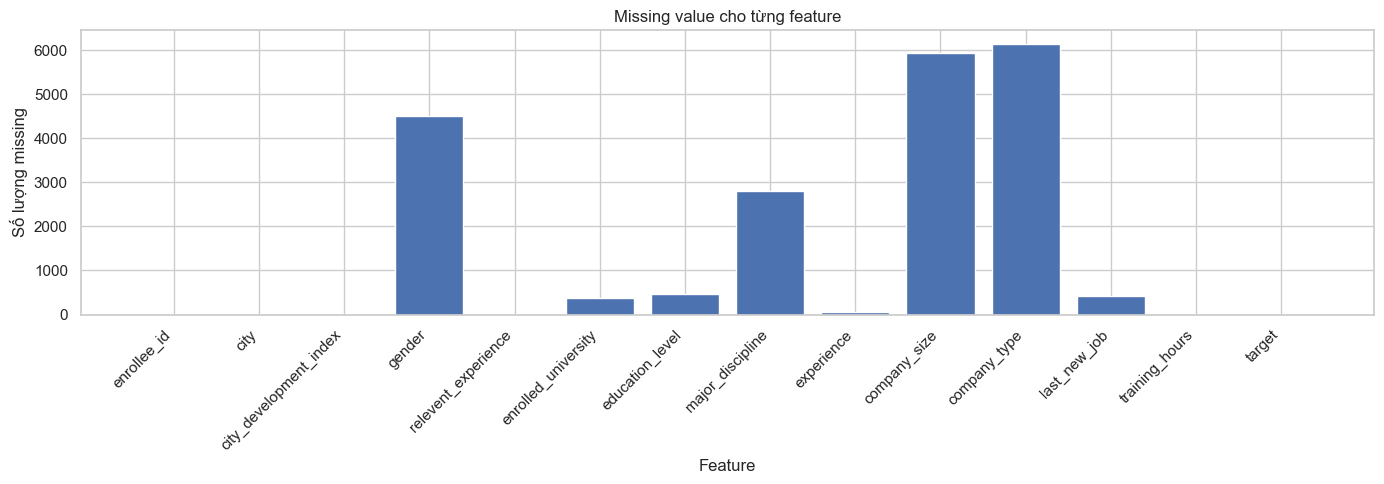

In [9]:
plot_missing_bar(header, missing_counts)

#### **Nhận xét**
Nhìn vào biểu đồ và số liệu thống kê, ta có thể thấy được số lượng missing khá lớn. Nhưng nhìn về mặt thực tế thì điều này là hoàn toàn bình thường. Cụ thể:

* **`company_size` & `company_type` (Thiếu nhiều nhất):** Lí do bị missing nhiều là vì ứng viên đó mới vừa ra trường chưa có việc hoặc có thể do đang thất nghiệp và mong muốn tìm công việc mới thông qua training này.
* **`gender` (thiếu khá nhiều):** Do ứng viên muốn giữ **quyền riêng tư** không muốn bị lộ giới tính. Điều này hoàn toàn bình thường.
* **`major_discipline` (thiếu tương đối nhiều):** Đây là sự thiếu hụt mang tính **logic**, vì những ứng viên có trình độ Cấp 3 (High School) trở xuống sẽ không có chuyên ngành đại học.

**Kết luận:** Các giá trị này bị khuyết có chủ đích (Not Missing At Random), mang ý nghĩa thông tin về hành vi ứng viên chứ không phải lỗi hệ thống.

### Kiểm tra invalid values cho các cột kiểu numeric

In [10]:
print("=" * 70)
print("   Kiểm tra các giá trị không hợp lệ cho từng feature kiểu numeric")
print("=" * 70)

is_invalid_any = False

for col_name in numeric_cols_raw:
    col = get_col(col_name)
    invalid_mask = [(not is_missing(x)) and (not is_float(x)) for x in col]
    invalid_vals = col[invalid_mask]

    if len(invalid_vals) > 0:
        is_invalid_any = True

        uniq, cnts = np.unique(invalid_vals, return_counts=True)

        order = np.argsort(-cnts)
        uniq = uniq[order]
        cnts = cnts[order]

        total_invalid = int(cnts.sum())

        print(f"\nCột '{col_name}': có {total_invalid} giá trị không hợp lệ")
        print("   Giá trị                     | Số lần xuất hiện")
        print("   ---------------------------+-----------------")

        max_show = 10
        for i, (u, c) in enumerate(zip(uniq, cnts)):
            if i == max_show:
                if len(uniq) > max_show:
                    print(f"   ... ({len(uniq) - max_show} giá trị khác)")
                break
            val_str = repr(u)
            print(f"   {val_str:<27} | {int(c):7d}")

if not is_invalid_any:
    print("Không tìm thấy giá trị không hợp lệ trong các cột numeric_raw.")


   Kiểm tra các giá trị không hợp lệ cho từng feature kiểu numeric
Không tìm thấy giá trị không hợp lệ trong các cột numeric_raw.


## II. Thống kê mô tả cho từng feature
**Mục tiêu của phần này:**

- Tóm tắt **hình dạng và phạm vi giá trị** của các biến trong dataset,
- Giúp ta có được cái nhìn tổng quan:
  - Numeric: giá trị nhỏ nhất, lớn nhất, trung bình, độ lệch chuẩn, và các phân vị (percentiles).
  - Categorical: có bao nhiêu loại giá trị khác nhau, những category nào xuất hiện nhiều nhất và chiếm tỷ lệ bao nhiêu.

Cụ thể:

#### 1. Đối với biến **numeric**

- Chuyển các cột số (đang đọc dưới dạng chuỗi) về dạng số thực (`float`), với:
  - Giá trị hợp lệ → số,
  - Giá trị không hợp lệ / thiếu → `NaN` (đã xử lý phần missing trước đó).
- Tính cho mỗi biến:
  - `min`, `max`
  - các phân vị: `5%`, `25%`, `50%` (median), `75%`, `95%`
  - `mean`, `std`
- Qua đó ta biết:
  - Biến nằm trong khoảng giá trị nào,
  - Có bị lệch mạnh không,
  - Có giá trị cực trị hay không.

#### 2. Đối với biến **categorical**
- Với từng cột:
  - Đếm số lượng category khác nhau,
  - Liệt kê **top-k category xuất hiện nhiều nhất**:
    - Số lần xuất hiện,
    - Tỷ lệ trên toàn bộ tập dữ liệu.
- Qua đó ta biết:
  - Biến có ít hay nhiều category (low/high cardinality),
  - Có bị **mất cân bằng mạnh** ở một vài category hay không,
  - Hỗ trợ quyết định cách encode (one-hot, gộp nhóm, v.v.) ở bước preprocessing.

---
### **Thống kê mô tả cho categorical**

In [11]:
def describe_categorical(col_name: str, top_k: int = 5):
    col = get_col(col_name)
    n_total = col.shape[0]

    # Lọc bỏ missing
    non_missing = np.array([x for x in col if not is_missing(x)])
    n_non_missing = len(non_missing)
    n_missing = n_total - n_non_missing

    print("=" * 70)
    print(f"\t\t\t[Feature] {col_name}")
    print("-" * 70)
    print(f"• Tổng số dòng          : {n_total}")
    print(f"• Số giá trị hợp lệ     : {n_non_missing} "
          f"({n_non_missing / n_total:5.1%} trên tổng số)")
    print(f"• Số giá trị missing    : {n_missing} "
          f"({n_missing / n_total:5.1%} trên tổng số)")
    
    if n_non_missing == 0:
        print("-> Cột này không có giá trị hợp lệ để thống kê.")
        print("=" * 70)
        return

    # Phân phối category
    values, counts = np.unique(non_missing, return_counts=True)
    n_unique = len(values)
    print(f"• Số lượng category khác nhau: {n_unique}")
    print()

    # Sắp xếp giảm dần theo tần suất
    idx_sorted = np.argsort(-counts)
    values = values[idx_sorted]
    counts = counts[idx_sorted]

    # Tỷ lệ theo non-missing và theo toàn bộ số dòng
    ratios_nonmiss = counts / n_non_missing
    ratios_total   = counts / n_total

    # Cột hiển thị: giới hạn độ dài category cho gọn
    max_cat_len = 30
    def fmt_cat(val):
        s = str(val)
        if len(s) > max_cat_len:
            return s[: max_cat_len - 3] + "..."
        return s

    k = min(top_k, n_unique)
    print(f"Top {k} category xuất hiện nhiều nhất:")
    header = (
        f"{'Category':<{max_cat_len}} | "
        f"{'Count':>8} | "
        f"{'% non-miss':>9} | "
        f"{'% total':>8}"
    )
    print(header)
    print("-" * len(header))

    for v, c, r_nm, r_t in zip(
        values[:k], counts[:k], ratios_nonmiss[:k], ratios_total[:k]
    ):
        cat_str = fmt_cat(v)
        print(
            f"{cat_str:<{max_cat_len}} | "
            f"{c:8d} | "
            f"{r_nm * 100:8.2f}% | "
            f"{r_t * 100:7.2f}%"
        )

    if n_unique > k:
        other_count = counts[k:].sum()
        other_ratio_nonmiss = other_count / n_non_missing
        other_ratio_total   = other_count / n_total
        print("-" * len(header))
        print(
            f"{'(others)':<{max_cat_len}} | "
            f"{other_count:8d} | "
            f"{other_ratio_nonmiss * 100:8.2f}% | "
            f"{other_ratio_total * 100:7.2f}%"
        )

    print("=" * 70)

In [12]:
print(f"\tSố lượng feature categorical được thống kê: {len(categorical_cols_raw)}\n")
for col_name in categorical_cols_raw:
    describe_categorical(col_name, top_k=3)
    print()

	Số lượng feature categorical được thống kê: 10

			[Feature] city
----------------------------------------------------------------------
• Tổng số dòng          : 19158
• Số giá trị hợp lệ     : 19158 (100.0% trên tổng số)
• Số giá trị missing    : 0 ( 0.0% trên tổng số)
• Số lượng category khác nhau: 123

Top 3 category xuất hiện nhiều nhất:
Category                       |    Count | % non-miss |  % total
-----------------------------------------------------------------
city_103                       |     4355 |    22.73% |   22.73%
city_21                        |     2702 |    14.10% |   14.10%
city_16                        |     1533 |     8.00% |    8.00%
-----------------------------------------------------------------
(others)                       |    10568 |    55.16% |   55.16%

			[Feature] gender
----------------------------------------------------------------------
• Tổng số dòng          : 19158
• Số giá trị hợp lệ     : 14650 (76.5% trên tổng số)
• Số giá trị missin

#### **Nhận xét**

Dựa trên thống kê, ta thấy bộ dữ liệu có đặc điểm **mất cân bằng (Imbalance)** cao và tập trung vào nhóm ứng viên có **trình độ chuyên môn**.

1. Sự mất cân bằng dữ liệu (Data Imbalance)
Các biến định danh cho thấy sự chênh lệch lớn giữa các nhóm, dễ gây bias cho mô hình:
   * **Giới tính (`gender`):** Nhóm **Male** chiếm áp đảo (**90.25%** số người khai báo). Nhóm Female và Other chỉ chiếm thiểu số rất nhỏ.
   * **Chuyên ngành (`major_discipline`):** **STEM** là nhóm chủ đạo (**88.66%** số người khai báo). Các ngành xã hội/nghệ thuật chiếm tỷ lệ không đáng kể có thể gộp chung thành nhóm "Non-STEM" để giảm nhiễu.
   * **Loại hình công ty (`company_type`):** Đa phần làm việc tại công ty tư nhân **Pvt Ltd** (**75.41%** số người khai báo).

2. Chân dung ứng viên (Candidate Profile)
Dữ liệu tập trung vào nhóm nhân sự đã trưởng thành và có trình độ cao, không phải sinh viên mới:
   * **Học vấn (`education_level`):** **85.35%** ứng viên có bằng Đại học (Graduate) hoặc Thạc sĩ (Masters).
   * **Kinh nghiệm (`relevent_experience`):** **72%** ứng viên đã có kinh nghiệm làm việc liên quan.
   * **Tình trạng học tập (`enrolled_university`):** **73.6%** không còn tham gia khóa học nào (`no_enrollment`).

3. Đặc điểm địa lý và nơi làm việc
   * **Thành phố (`city`):** Dù có 123 thành phố, dữ liệu bị phân cực mạnh. Chỉ riêng 3 thành phố đứng đầu (`city_103`, `city_21`, `city_16`) đã chiếm khoảng **45%** lượng dữ liệu.
   * **Quy mô công ty (`company_size`):** Phân bố khá rải rác, nhưng nhóm công ty nhỏ (50-99) và vừa (100-500) chiếm tỷ trọng lớn nhất trong số những người khai báo.

4. Kinh nghiệm làm việc (`experience`)
   * **Phân phối:** Tập trung lớn vào nhóm nhân sự **dày dạn kinh nghiệm**. Nhóm **`>20` năm** chiếm tỷ trọng cao nhất (**17.21%**).
   * **Đặc điểm:** Dữ liệu bị chặn trên (Right-censored) tại mốc 20 năm, tức là 21 năm hay 30 năm kinh nghiệm đều bị gộp chung.

5. Khoảng cách lần nhảy việc cuối (`last_new_job`)
   * **Phân phối:** Có sự phân cực rõ rệt giữa hai nhóm:
     * Nhóm **mới thay đổi công việc** (1 năm): Chiếm đa số áp đảo (**42.91%**).
     * Nhóm **ổn định lâu dài** (`>4` năm): Chiếm vị trí thứ 2 (**17.56%**).

---

### **Thống kê mô tả cho numeric**

Để có thể thống kê mô tả cho các biến numeric ở bộ dữ liệu này, ta cần **biến đổi giá trị của các cột sang dạng số**. Khi quan sát dữ liệu gốc, ta thấy:

- Một số cột **thực chất là số nhưng được lưu dưới dạng chuỗi** trong file CSV.
- Nếu giữ nguyên dạng chuỗi, ta không thể:
  - Tính các thống kê như min, max, mean, percentiles,
  - Cũng như không thể vẽ đúng histogram, boxplot hoặc kiểm tra outlier.

Cụ thể trong bộ dữ liệu này, các cột được xử lý như numeric gồm:

1. **`city_development_index`**  
   - Giá trị đã là số thập phân, thường nằm trong khoảng từ 0 đến 1.  
   - Dữ liệu gốc được đọc lên dưới dạng chuỗi, nên ta cần chuyển toàn bộ về kiểu `float`.  
   - Các giá trị thiếu giữ nguyên dưới dạng `NaN`.  
   - Sau khi chuyển đổi, ta có thể:
     - Tính các thống kê cơ bản (min, max, mean, median, phân vị),
     - Vẽ histogram, boxplot,  
     - Kiểm tra phân bố và outlier.

2. **`training_hours`**  
   - Là số giờ training đã hoàn thành, giá trị là số nguyên không âm, nhưng trong file CSV vẫn được lưu dạng chuỗi.  
   - Ta chuyển toàn bộ sang dạng số thực (`float`) và gán `NaN` cho các giá trị thiếu.  
   - Điều này giúp ta:
     - Phân tích phân bố số giờ training (histogram, ECDF),
     - So sánh `training_hours` giữa nhóm đổi job và không đổi job,
     - Kiểm tra các giá trị bất thường (rất lớn hoặc bằng 0).

In [13]:
def get_numeric_array(col_name: str) -> np.ndarray:
    col = get_col(col_name)
    return string_column_to_float(col)

In [14]:
cdi = get_numeric_array("city_development_index")
training_hours = get_numeric_array("training_hours")

numeric_arrays = {
    "city_development_index": cdi,
    "training_hours": training_hours,
}

header_fmt = (
    f"{'Feature':25s} | {'min':>8s} | {'5%':>8s} | {'25%':>8s} | {'50%':>8s} | "
    f"{'75%':>8s} | {'95%':>8s} | {'max':>8s} | {'mean':>8s} | {'std':>8s}"
)

print(header_fmt)
print("-" * len(header_fmt))

row_fmt = (
    "{name:25s} | {min:8.3f} | {p5:8.3f} | {p25:8.3f} | {p50:8.3f} | "
    "{p75:8.3f} | {p95:8.3f} | {max:8.3f} | {mean:8.3f} | {std:8.3f}"
)

for name, arr in numeric_arrays.items():
    x = arr[~np.isnan(arr)]
    if x.size == 0:
        continue

    q5, q25, q50, q75, q95 = np.percentile(x, [5, 25, 50, 75, 95])
    
    print(row_fmt.format(
        name=name,
        min=np.min(x),
        p5=q5,
        p25=q25,
        p50=q50,
        p75=q75,
        p95=q95,
        max=np.max(x),
        mean=np.mean(x),
        std=np.std(x, ddof=1),
    ))

Feature                   |      min |       5% |      25% |      50% |      75% |      95% |      max |     mean |      std
----------------------------------------------------------------------------------------------------------------------------
city_development_index    |    0.448 |    0.624 |    0.740 |    0.903 |    0.920 |    0.926 |    0.949 |    0.829 |    0.123
training_hours            |    1.000 |    7.000 |   23.000 |   47.000 |   88.000 |  188.000 |  336.000 |   65.367 |   60.058


#### **Nhận xét**

Dựa trên các chỉ số thống kê, ta thấy hai biến này có đặc điểm phân phối hoàn toàn trái ngược nhau:

**1. `city_development_index` (Phân phối lệch trái - Left Skewed):**
* **Mean (0.829) < Median (0.903)**.
* Dữ liệu tập trung dày đặc ở ngưỡng cao. Cho thấy phần lớn ứng viên đến từ các thành phố rất phát triển (Index > 0.9).

**2. `training_hours` (Phân phối lệch phải - Right Skewed):**
* **Mean (65.3) > Median (47.0)**.
* Độ lệch chuẩn lớn (**Std ~ 60**) cho thấy sự chênh lệch lớn trong thời gian đào tạo giữa các ứng viên.
* **Outliers:** Có xuất hiện các giá trị ngoại lai rất lớn (Max = 336 so với 75% = 88), cần lưu ý khi xử lý (có thể dùng Log transformation hoặc Robust Scaler).

**Note cho phần processing:**
Do thang đo (scale) của hai biến này chênh lệch quá lớn (0-1 so với 1-336), rất nên thực hiện **Feature Scaling** (như MinMax Scaler hoặc Standard Scaler) trước khi đưa vào train model.

---

### **Xác định Outliers cho numeric**
- Dùng phương pháp IQR (Q1, Q3, IQR) để xác định outlier:
  - `value < Q1 - 1.5 * IQR` hoặc `value > Q3 + 1.5 * IQR`.
- Đếm số lượng outliers ở mỗi feature numeric.

In [15]:
print("  SỐ LƯỢNG OUTLIERS THEO TỪNG FEATURE NUMERIC (IQR)")
print("="*50)

header_fmt = f"{'Feature':25s} | {'Outliers':>10s}"
print(header_fmt)
print("-"*50)

row_fmt = "{name:25s} | {out:10d}"

for name, arr in numeric_arrays.items():
    mask_out = detect_outliers_iqr(arr)
    num_out = np.sum(mask_out & ~np.isnan(arr))
    print(row_fmt.format(name=name, out=num_out))

print("="*50)

  SỐ LƯỢNG OUTLIERS THEO TỪNG FEATURE NUMERIC (IQR)
Feature                   |   Outliers
--------------------------------------------------
city_development_index    |         17
training_hours            |        984


#### Visualization

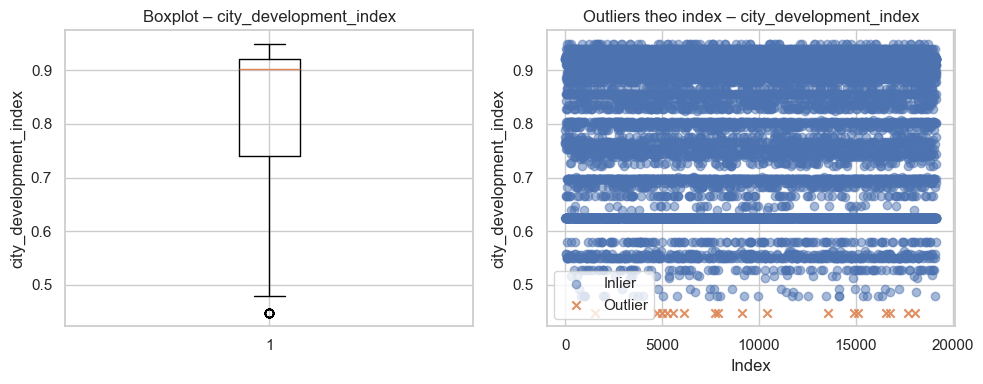

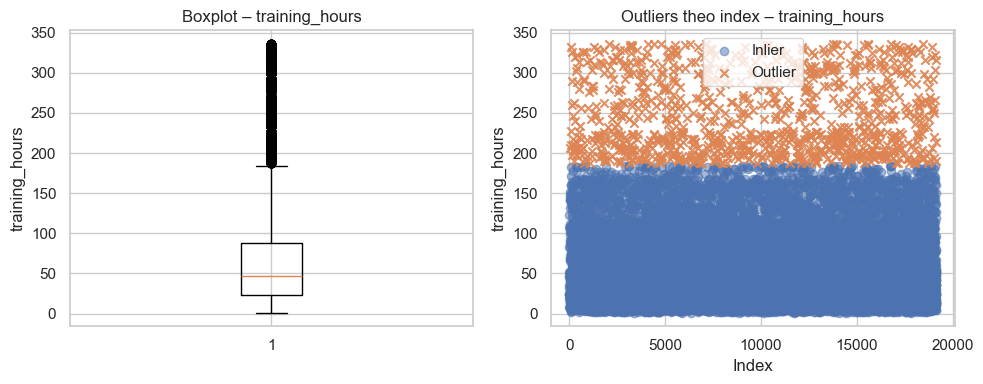

In [16]:
for name, arr in numeric_arrays.items():
    mask_out = detect_outliers_iqr(arr)
    plot_outliers(arr, mask_out, name)

#### **Nhận xét**

Biểu đồ cho thấy sự đối lập hoàn toàn về cách phân bố ngoại lai giữa hai biến định lượng này:

**1. `city_development_index` (Chỉ số phát triển thành phố):**
* **Số lượng Outliers:** Rất ít, chỉ có **17** mẫu (chiếm tỷ lệ không đáng kể).
* **Vị trí:** Nằm ở phía **dưới** (Low extreme values).
* **Ý nghĩa:** Đây là phân phối lệch trái (Left-skewed). Các điểm ngoại lai đại diện cho một nhóm rất nhỏ ứng viên đến từ các thành phố kém phát triển (Index < 0.5), trong khi đại đa số nằm ở vùng phát triển cao.
* **Hướng xử lí cho phần preprocessing:** Do số lượng quá ít và không phải lỗi dữ liệu, có thể **giữ nguyên**.

**2. `training_hours` (Số giờ đào tạo):**
* **Số lượng Outliers:** Rất lớn, lên tới **984** mẫu (chiếm khoảng ~5% dữ liệu).
* **Vị trí:** Nằm tập trung dày đặc ở phía **trên** (High extreme values).
* **Ý nghĩa:** Phân phối lệch phải (Right-skewed). Các outlier này không phải nhiễu (noise) mà là **tín hiệu thật** (valid data points), đại diện cho nhóm ứng viên cực kỳ chăm chỉ (học > 180 giờ), khác biệt hẳn so với mặt bằng chung (học ~50 giờ).
* **Hướng xử lí cho phần preprocessing:**
   - **Không nên xóa:** Vì đây là thông tin quan trọng (chẳng hạn như: có thể nhóm học nhiều sẽ ít nhảy việc hơn).
   - **Cần Transformation:** Nên dùng **Log Transformation** hoặc **Robust Scaler** để giảm bớt ảnh hưởng của các giá trị cực đại này khi đưa vào mô hình.

## III. Phân phối của các feature
### **Phân phối của Target**

Phân phối target:
target=0 : 14381 mẫu (75.07%)
target=1 : 4777 mẫu (24.93%)



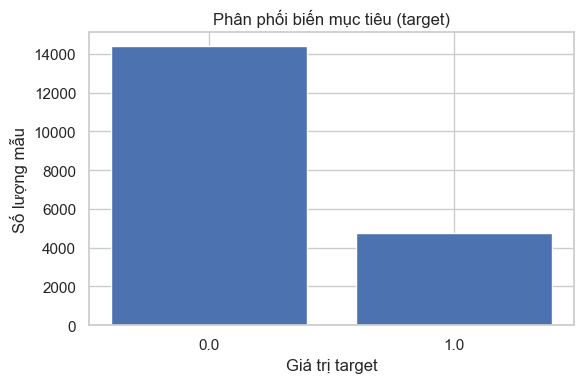

In [17]:
target = get_numeric_array("target")

plot_target_distribution(target)

#### **Nhận xét**
Phân phối của biến `target` cho thấy hiện tượng **mất cân bằng dữ liệu mức độ trung bình (Moderate Imbalance)**:

* **Nhóm ở lại (`target=0`):** Chiếm đa số với **75.07%**.
* **Nhóm muốn chuyển việc (`target=1`):** Chiếm **24.93%** (Tỷ lệ khoảng 1:3).

**Ảnh hưởng:**
1. **Rủi ro:** Mô hình có xu hướng thiên vị nhóm đa số (`0`). Nếu dự đoán "toàn bộ là 0", độ chính xác mặc nhiên đạt ~75% (Null Accuracy), nhưng mô hình vô dụng.
2. **Đánh giá:** Không sử dụng *Accuracy* làm thước đo chính. Cần tối ưu hóa **F1-Score** và **ROC-AUC**.
3. **Xử lý:**
   - Cần thiết lập `stratify=y` khi chia tập Train/Test để đảm bảo tỷ lệ 25% được giữ nguyên trong cả hai tập.
   - Có thể cân nhắc kỹ thuật *Class Weighting* hoặc *Resampling (SMOTE)* nếu mô hình dự đoán kém trên nhóm 1.
---

### **Phân phối cho numeric**

Ở phần này, ta quan sát phân phối của các feature dạng numeric bằng **Histogram**, **KDE** và **ECDF**.

- **Histogram**: cho thấy tần suất xuất hiện của giá trị trong từng khoảng → nhìn được độ lệch và dạng phân phối.  
- **KDE**: đường mật độ mượt giúp nhận biết xu hướng tổng thể và số lượng mode.  
- **ECDF**: biểu diễn tỷ lệ dữ liệu ≤ một giá trị để dễ thấy median, các bước nhảy và mức độ tích lũy.

Feature city_development_index:


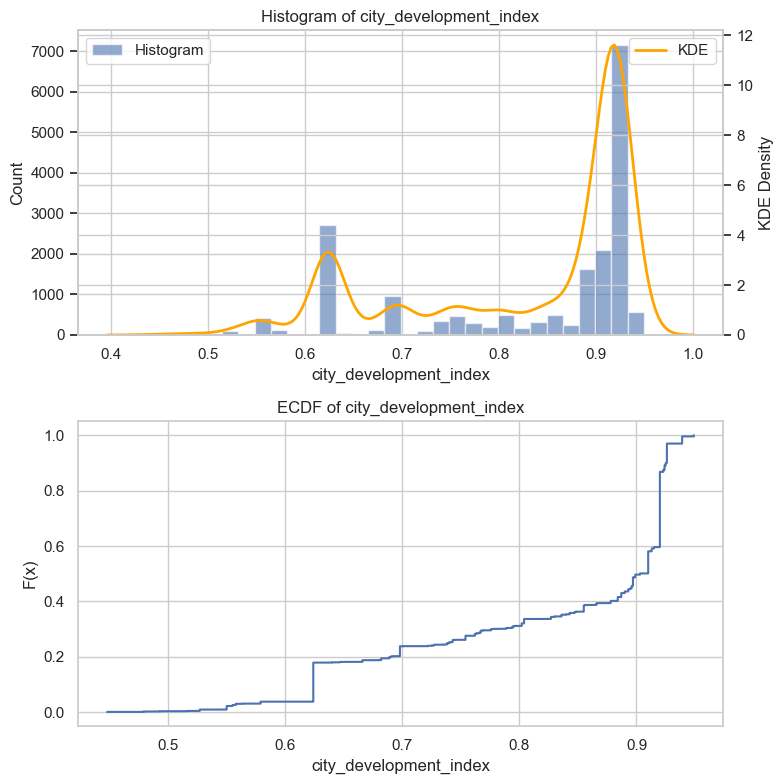

Feature training_hours:


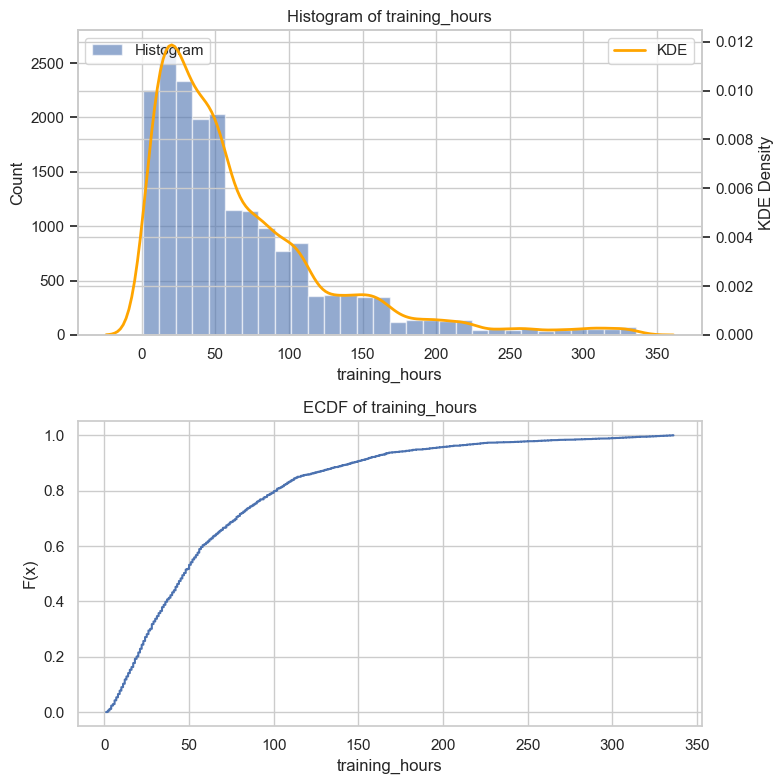

In [18]:
for name, arr in numeric_arrays.items():
    print(f"Feature {name}:")
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    plot_numeric_distribution(arr, name, bins=30, show_kde=True, log_scale=False, ax=axes[0])
    plot_ecdf(arr, name, ax=axes[1])
    plt.tight_layout()
    plt.show()

#### **Nhận xét**

Giống với phân tích ở phần thống kê mô tả, hai feature numeric này có hình dáng phân phối trái ngược nhau hoàn toàn, đòi hỏi các kỹ thuật xử lý khác nhau:

1. `training_hours` (Số giờ đào tạo) - Phân phối lệch phải (Right-Skewed)
   * **Hình dáng (Histogram):** Dữ liệu có dạng giống phân phối **Log-normal** hoặc **Exponential**. Đỉnh (Peak) tập trung ở vùng giá trị thấp (khoảng 20-50 giờ). Đuôi bên phải kéo rất dài.
   * **Tích lũy (ECDF):**
       * Đường cong tăng rất dốc ở đoạn đầu: Khoảng **80% ứng viên** có số giờ training dưới **100 giờ**.
       * Đoạn sau phẳng lì: Chỉ có một nhóm rất nhỏ (top 5%) có số giờ training > 200.
   * **Kết luận:** Đa số mọi người chỉ học các khóa ngắn hạn.
   * **Hướng xử lý cho phần preprecessing:** Có thể sẽ áp dụng **Log Transformation** (lấy logarit) hoặc **Box-Cox Transformation** để đưa phân phối về dạng gần chuẩn (Normal) hơn, giúp mô hình học tốt hơn.

2. `city_development_index` (Chỉ số phát triển) - Phân phối đa đỉnh & Lệch trái
   * **Hình dáng (Histogram):** Không tuân theo phân phối chuẩn. Nó là phân phối **Đa đỉnh (Multimodal)**:
       * Đỉnh chính (Major Peak): Rất cao ở vùng **> 0.9** (các thành phố rất phát triển).
       * Đỉnh phụ (Minor Peak): Một nhóm nhỏ tập trung quanh mức **0.62**.
   * **Tích lũy (ECDF):**
       * Đường ECDF có dạng **bậc thang (Step function)** thay vì đường cong mượt.
       * **Ý nghĩa:** Điều này chứng tỏ giá trị `city_development_index` không liên tục ngẫu nhiên mà bị ngắt quãng theo từng nhóm thành phố cụ thể.
   * **Kết luận:** Dữ liệu bị phân cực. Ứng viên chủ yếu đến từ các "siêu đô thị" (Index > 0.9).
   * **Hướng xử lý cho phần preprecessing:** Có thể cân nhắc **Binning** (chia nhóm) biến này thành các khoảng (ví dụ: High, Medium, Low) thay vì để nguyên giá trị số thực, để mô hình dễ bắt được các cụm (cluster) này. Hoặc nếu có nhiều thời gian hơn, ta vẫn giữ biến này ở dạng numeric liên tục (clip + z-score), và vừa mở rộng thêm một phiên bản binned (Low/Medium/High) để thử trong modeling.

---
### **Phân phối các biến categorical**

Ở phần này, ta trực quan hóa các feature dạng *categorical* bằng **biểu đồ bar** và **biểu đồ tròn (pie chart)**.

- **Bar chart**: cho thấy số lượng/tần suất từng category, dễ so sánh giữa các nhóm.  
- **Pie chart**: giúp quan sát tỷ lệ phần trăm của các nhóm chính, phù hợp khi chỉ xem top-k category.  
- Với các feature có quá nhiều giá trị (như `city`), ta chỉ xem **top 10** để biểu đồ rõ ràng hơn.

Từ đó ta có thể đánh giá được bộ dữ liệu này sẽ chủ yếu là 'nhóm người' như thế nào.

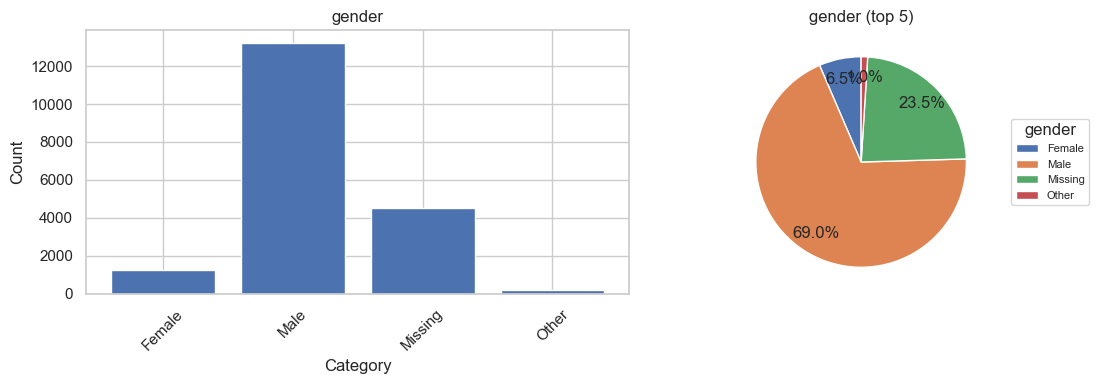

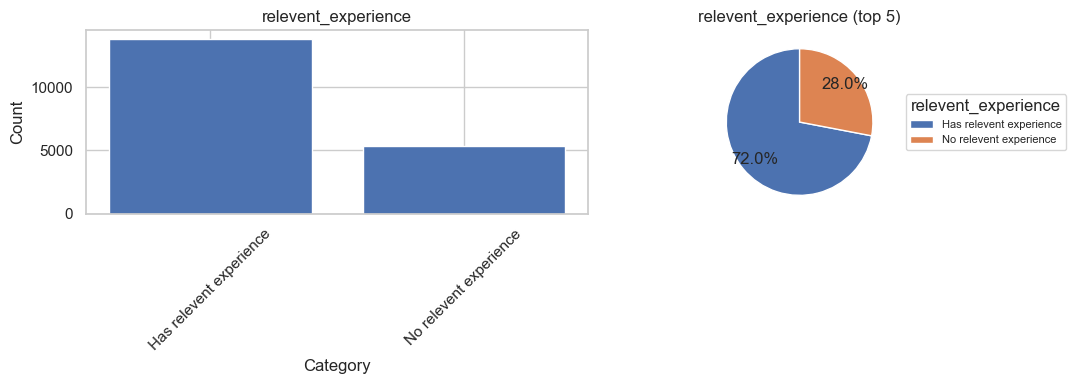

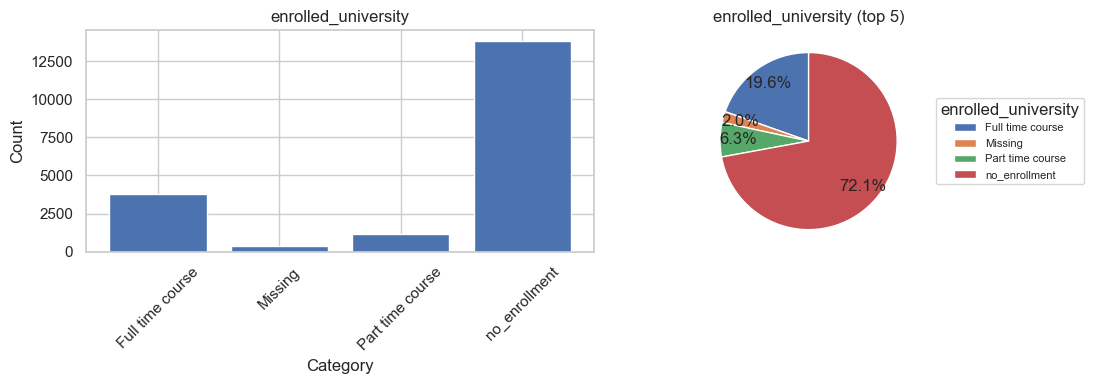

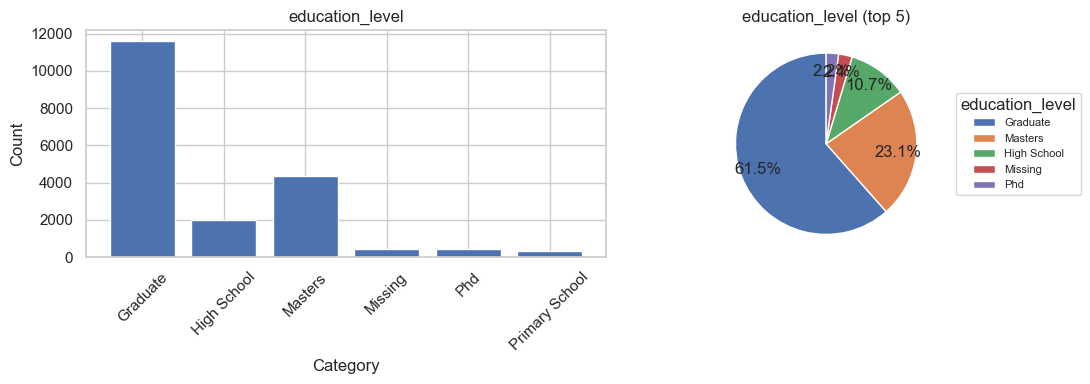

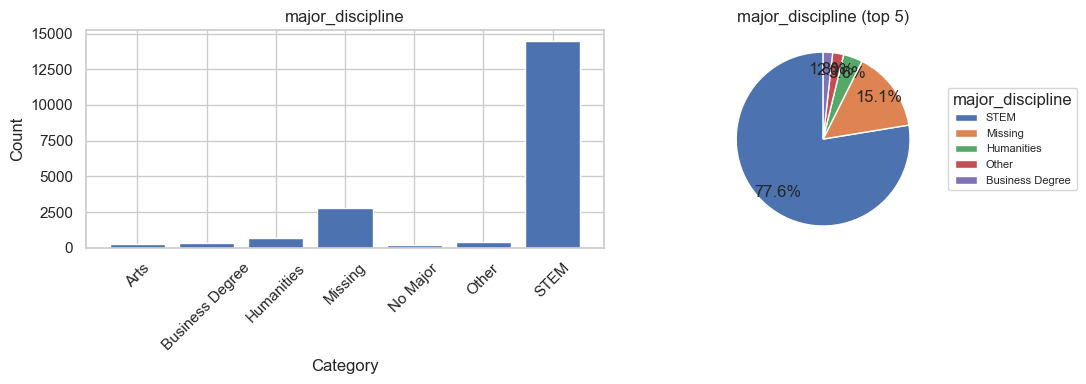

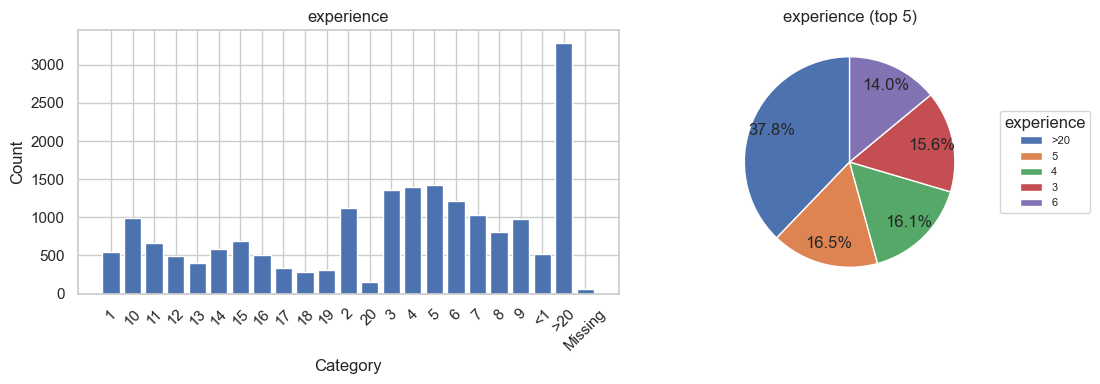

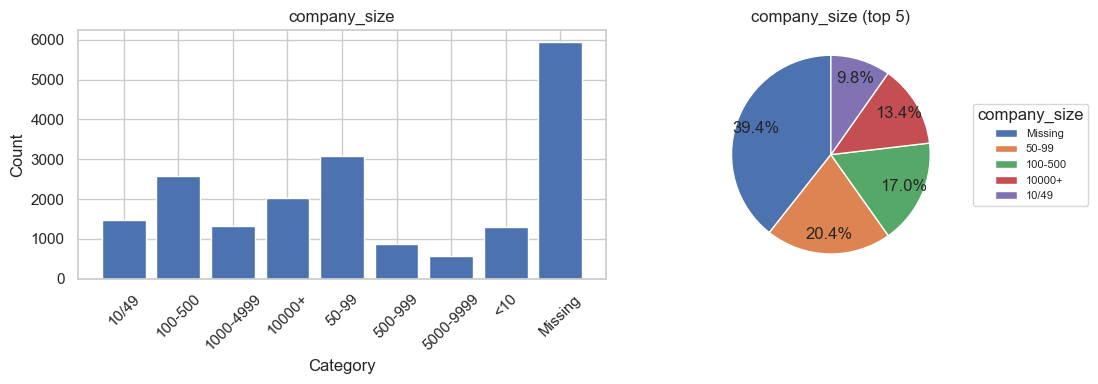

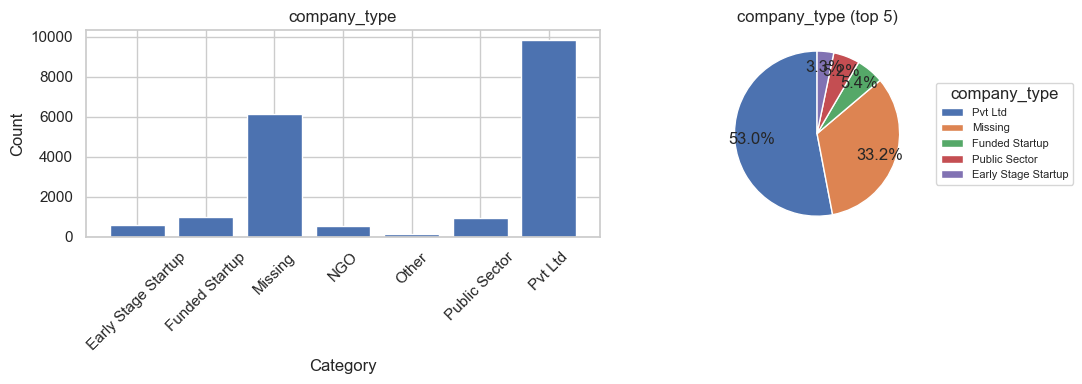

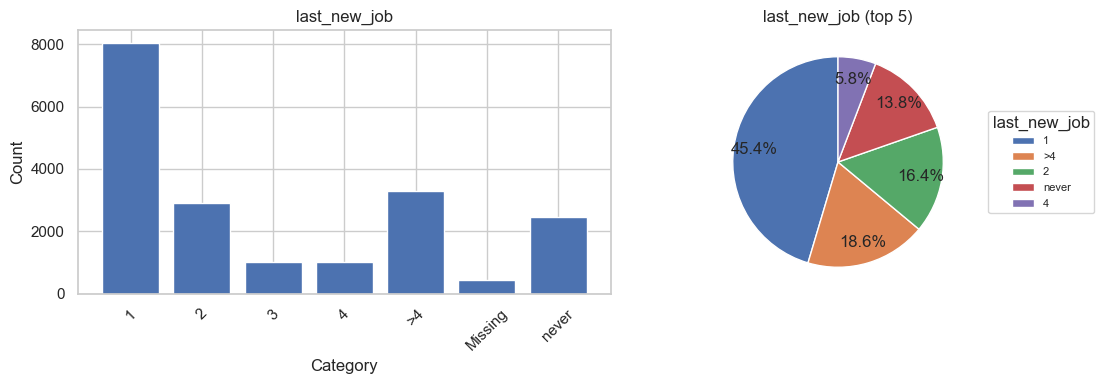

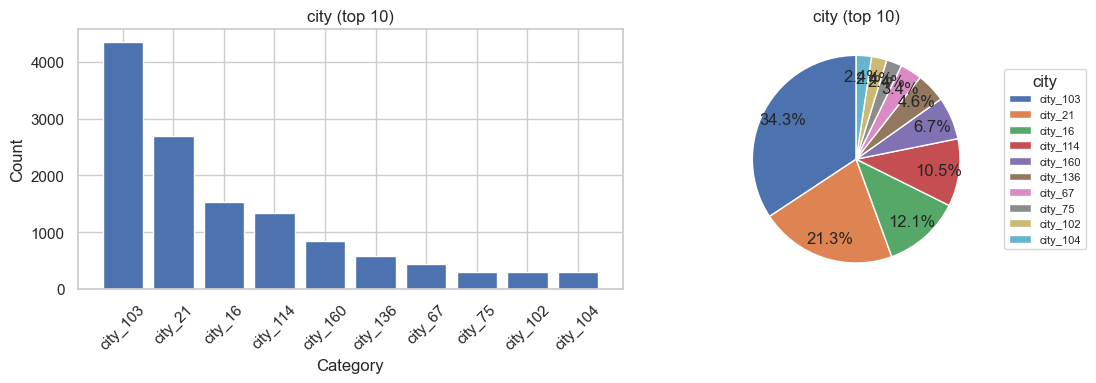

In [19]:
for col_name in categorical_cols_raw:
    if col_name == "city":
        continue
    col_data = get_col(col_name)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_categorical_distribution(col_data, col_name, ax=axes[0])
    plot_pie(col_data, col_name, top_k=5, ax=axes[1])
    plt.tight_layout()
    plt.show()

city_col = get_col("city")
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_categorical_distribution(city_col, "city (top 10)", top_k=10, ax=axes[0])
plot_pie(city_col, "city", top_k=10, ax=axes[1])
plt.tight_layout()
plt.show()
# Note: title 'Missing' nghĩa là Missing value trong feauture

#### **Nhận xét**

Ta sẽ bỏ qua về phần phân tích từng feature vì điều đó đã được nói rõ ở phần "Thống kê mô tả" vì vậy ở đây ta sẽ tập trung vào phần phân tích dựa trên sự kết hợp các feature cũng như liên hệ với thực tế hơn. Dựa trên trực quan hóa dữ liệu, ta có thể phác họa rõ nét **"Đặc điểm ứng viên" (Candidate Persona)** và các đặc điểm nổi bật của tập dữ liệu:

1. Đặc điểm của ứng viên kiểu "Dân Tech chuyên môn cao & Dày dạn kinh nghiệm"
   * **Trình độ học vấn (`education_level` & `major_discipline`):**
       * Nhóm ngành **STEM** chiếm vị thế độc tôn (**77.6%**).
       * Đa số ứng viên có bằng Đại học (**Graduate - 61.5%**) hoặc Thạc sĩ (**Masters - 23.1%**).
       * $\to$ Đây là tập dữ liệu của giới trí thức kỹ thuật, nhân sự chất lượng cao.
   * **Kinh nghiệm làm việc (`relevent_experience` & `experience`):**
       * **72%** ứng viên đã có kinh nghiệm làm việc liên quan đến lĩnh vực này.
       * Nhóm nhân sự cấp cao (**>20 năm kinh nghiệm**) chiếm tỷ trọng lớn nhất trong phân phối kinh nghiệm.
   * **Tình trạng hiện tại (`enrolled_university`):**
       * **72.1%** không còn đi học (`no_enrollment`), khẳng định đây là nhóm nhân sự đang đi làm toàn thời gian.

2. Hành vi nghề nghiệp & Môi trường làm việc
   * **Loại hình công ty (`company_type`):**
       * Phần lớn làm việc tại các công ty Tư nhân (**Pvt Ltd**), chiếm **53%**. Các mô hình Startup hay NGO chiếm tỷ lệ rất nhỏ.
   * **Quy mô công ty (`company_size`):**
       * Dữ liệu tại cột này bị khuyết rất nhiều (**~40% là Missing**). Trong số những người khai báo, nhóm công ty quy mô nhỏ (50-99 nhân viên) chiếm đa số.
   * **Tần suất nhảy việc (`last_new_job`):**
       * Nhóm phổ biến nhất là **1 năm** (**45.4%**). Điều này cho thấy sự biến động nhân sự trong ngành Tech khá cao, ứng viên có xu hướng thay đổi môi trường hoặc mới bắt đầu công việc mới gần đây.

3. Các yếu tố về Nhân khẩu học & Địa lý
   * **Giới tính (`gender`):**
       * Mất cân bằng nghiêm trọng với **Nam giới** chiếm đa số. Tuy nhiên, lượng dữ liệu bị thiếu (`Missing`) ở cột này cũng rất cao (**23.5%**).
   * **Địa lý (`city`):**
       * Có sự tập trung cục bộ mạnh mẽ. Chỉ riêng **`city_103`** đã chiếm tới **34.3%** tổng dữ liệu, cho thấy đây có thể là một "Tech Hub" lớn.

**Tóm lại:**
Bộ dữ liệu phản ánh một thị trường nhân lực trong ngành Khoa học dữ liệu chủ yếu sẽ có đặc điểm là **Nam giới**, thuộc khối **STEM**, trình độ **Đại học trở lên**, làm việc chủ yếu ở khối **Tư nhân**.

---

## IV. Mối quan hệ giữa các feature với `target`

Trong phần này, ta phân tích xem các đặc trưng (feature) liên quan thế nào đến
khả năng ứng viên muốn thay đổi công việc (`target = 1`).

Ta chia làm 2 nhóm:

### **Nhóm 1: Categorical vs `target`**

Với mỗi biến categorical quan trọng, ta sẽ:

- Nhóm dữ liệu theo từng category.
- Tính **tỷ lệ `target = 1`** trong mỗi nhóm.
- Vẽ bar chart (`plot_target_rate_by_category`) để trực quan hóa.

Phần này giúp ta hiểu thêm về:

- Ứng viên có **kinh nghiệm liên quan** (`relevent_experience`) có xu hướng đổi job
  nhiều hơn người **chưa có kinh nghiệm** không?
- **Trình độ học vấn** (`education_level`) ảnh hưởng thế nào đến khả năng đổi job?
- **Ngành học / chuyên ngành** (`major_discipline`) có tạo ra sự khác biệt đáng kể
  về tỷ lệ đổi việc không?
- Một số đặc trưng khác như `gender`, `company_size`, `company_type` có tác động gì
  đến xu hướng đổi job?
- `experience` (số năm kinh nghiệm) ảnh hưởng thế nào đến khả năng đổi việc?

### **Nhóm 2: Numeric vs `target`**

Với các biến numeric, ta sẽ:

- Dùng `boxplot_numeric_by_target`:
  - So sánh **phân phối**, **median** và **độ phân tán** giữa hai nhóm
    `target = 0` (không đổi job) và `target = 1` (muốn đổi job).
- Dùng `plot_hist_overlay_by_target`:
  - Vẽ **histogram overlay** của hai nhóm trên cùng một trục để so sánh trực quan.

Phần này giúp ta hiểu thêm về:

- `city_development_index` (chỉ số phát triển của thành phố) có mối liên hệ gì
  với xu hướng đổi job (người ở thành phố phát triển cao có dễ đổi việc hơn không)?
- `training_hours` (số giờ training) có khác biệt rõ rệt giữa người đổi job
  và không đổi job hay không?

Kết quả phân tích ở phần này sẽ là cơ sở quan trọng cho việc:
- Chọn feature quan trọng,
- Thiết kế đặc trưng (feature engineering),
- Và giải thích mô hình Logistic Regression ở các bước sau.

---

### **Nhóm 1: Categorical vs `target`**


	    Tỷ lệ target = 1 theo 'city':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
city_171                     |      1 |  1.000 |     100.00%
city_139                     |      5 |  0.800 |      80.00%
city_155                     |     14 |  0.786 |      78.57%
city_42                      |     13 |  0.692 |      69.23%
city_107                     |      6 |  0.667 |      66.67%
city_33                      |     17 |  0.647 |      64.71%
city_179                     |      5 |  0.600 |      60.00%
city_11                      |    247 |  0.595 |      59.51%
city_21                      |   2702 |  0.591 |      59.10%
city_145                     |     63 |  0.587 |      58.73%
city_43                      |     12 |  0.583 |      58.33%
city_101                     |     75 |  0.573 |      57.33%
city_128 

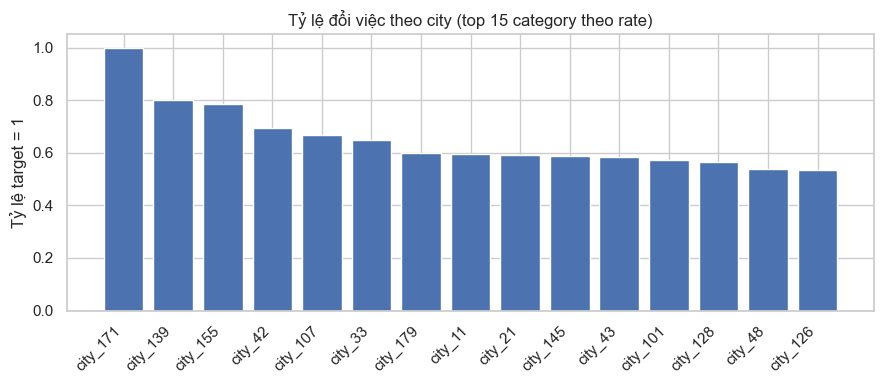


	    Tỷ lệ target = 1 theo 'gender':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
MISSING                      |   4508 |  0.308 |      30.81%
Female                       |   1238 |  0.263 |      26.33%
Other                        |    191 |  0.262 |      26.18%
Male                         |  13221 |  0.228 |      22.78%


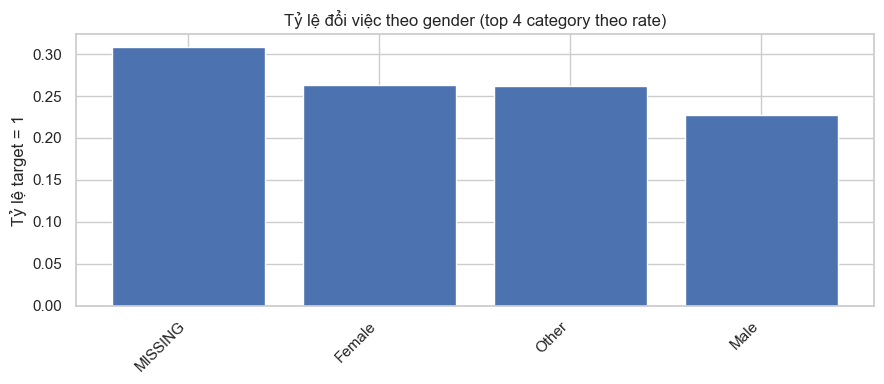


	    Tỷ lệ target = 1 theo 'relevent_experience':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
No relevent experience       |   5366 |  0.338 |      33.84%
Has relevent experience      |  13792 |  0.215 |      21.47%


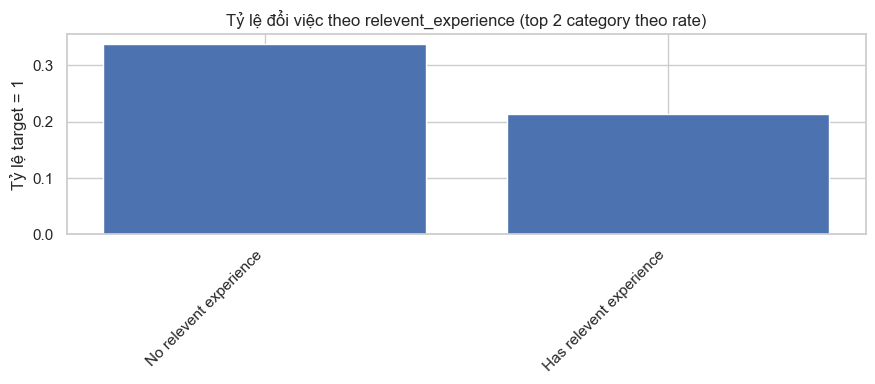


	    Tỷ lệ target = 1 theo 'enrolled_university':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
Full time course             |   3757 |  0.381 |      38.09%
MISSING                      |    386 |  0.319 |      31.87%
Part time course             |   1198 |  0.252 |      25.21%
no_enrollment                |  13817 |  0.211 |      21.14%


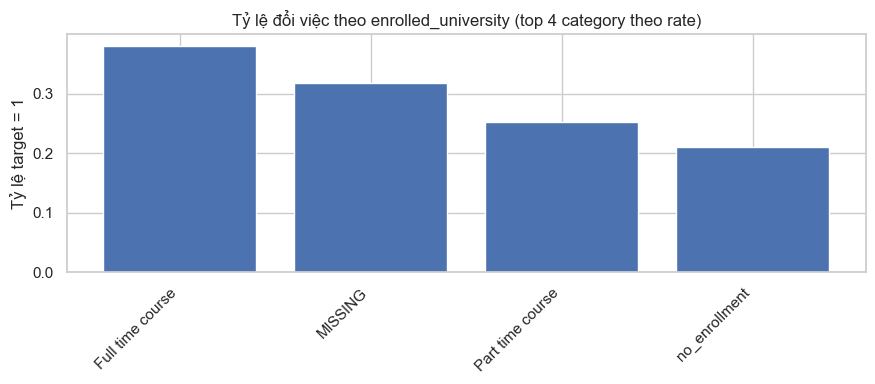


	    Tỷ lệ target = 1 theo 'education_level':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
Graduate                     |  11598 |  0.280 |      27.98%
MISSING                      |    460 |  0.226 |      22.61%
Masters                      |   4361 |  0.214 |      21.44%
High School                  |   2017 |  0.195 |      19.53%
Phd                          |    414 |  0.140 |      14.01%
Primary School               |    308 |  0.133 |      13.31%


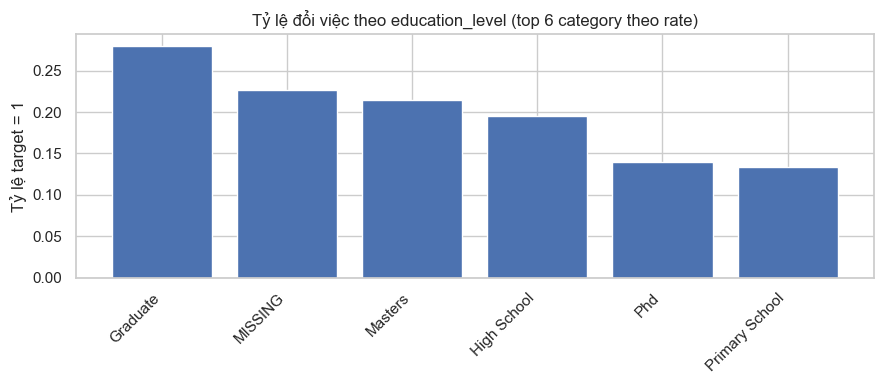


	    Tỷ lệ target = 1 theo 'major_discipline':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
Other                        |    381 |  0.268 |      26.77%
Business Degree              |    327 |  0.263 |      26.30%
STEM                         |  14492 |  0.262 |      26.16%
No Major                     |    223 |  0.247 |      24.66%
Humanities                   |    669 |  0.211 |      21.08%
Arts                         |    253 |  0.209 |      20.95%
MISSING                      |   2813 |  0.195 |      19.52%


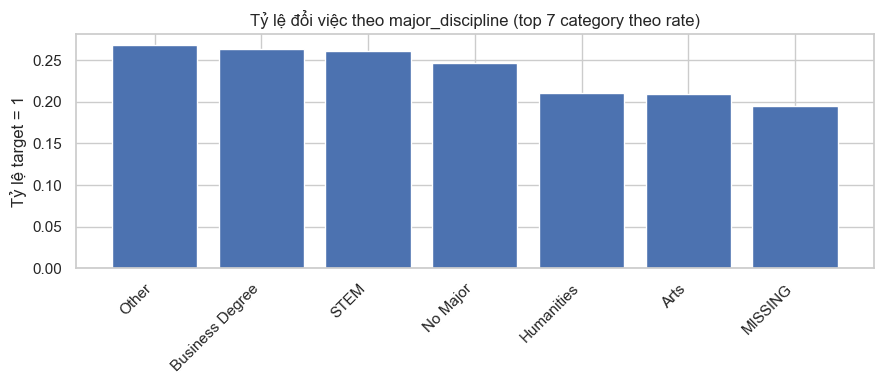


	    Tỷ lệ target = 1 theo 'experience':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
<1                           |    522 |  0.454 |      45.40%
1                            |    549 |  0.424 |      42.44%
MISSING                      |     65 |  0.354 |      35.38%
3                            |   1354 |  0.353 |      35.30%
2                            |   1127 |  0.332 |      33.19%
4                            |   1403 |  0.326 |      32.57%
7                            |   1028 |  0.295 |      29.47%
5                            |   1430 |  0.288 |      28.81%
6                            |   1216 |  0.282 |      28.21%
8                            |    802 |  0.243 |      24.31%
11                           |    664 |  0.227 |      22.74%
20                           |    148 |  0.223 |      22.30%
9  

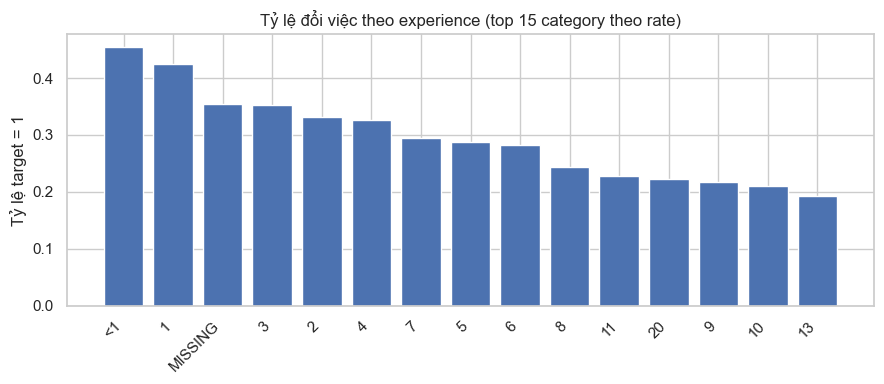


	    Tỷ lệ target = 1 theo 'company_size':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
MISSING                      |   5938 |  0.406 |      40.59%
10/49                        |   1471 |  0.234 |      23.39%
10000+                       |   2019 |  0.191 |      19.07%
5000-9999                    |    563 |  0.181 |      18.12%
50-99                        |   3083 |  0.177 |      17.68%
500-999                      |    877 |  0.173 |      17.33%
<10                          |   1308 |  0.171 |      17.13%
100-500                      |   2571 |  0.161 |      16.14%
1000-4999                    |   1328 |  0.151 |      15.06%


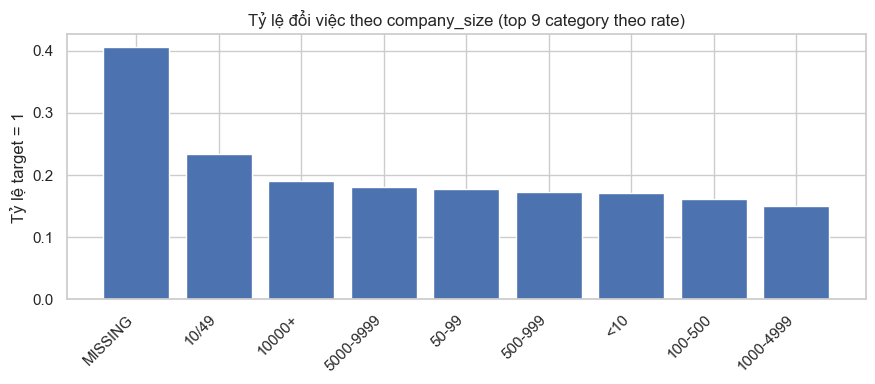


	    Tỷ lệ target = 1 theo 'company_type':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
MISSING                      |   6140 |  0.388 |      38.83%
Other                        |    121 |  0.240 |      23.97%
Early Stage Startup          |    603 |  0.235 |      23.55%
Public Sector                |    955 |  0.220 |      21.99%
NGO                          |    521 |  0.186 |      18.62%
Pvt Ltd                      |   9817 |  0.181 |      18.08%
Funded Startup               |   1001 |  0.140 |      13.99%


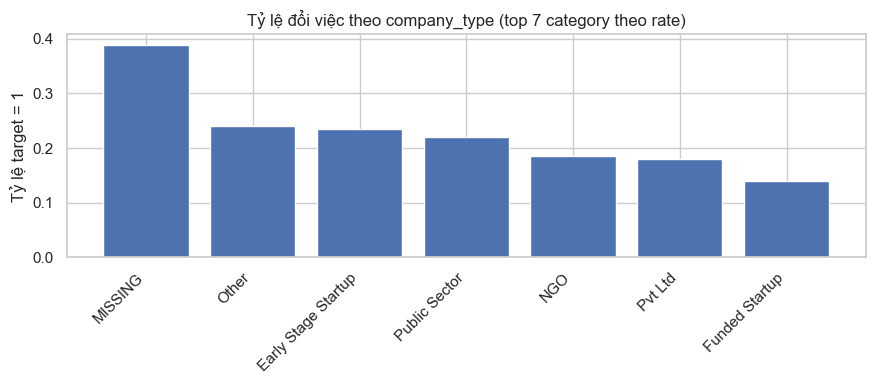


	    Tỷ lệ target = 1 theo 'last_new_job':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
MISSING                      |    423 |  0.364 |      36.41%
never                        |   2452 |  0.301 |      30.14%
1                            |   8040 |  0.264 |      26.43%
2                            |   2900 |  0.241 |      24.14%
3                            |   1024 |  0.226 |      22.56%
4                            |   1029 |  0.222 |      22.16%
>4                           |   3290 |  0.182 |      18.24%


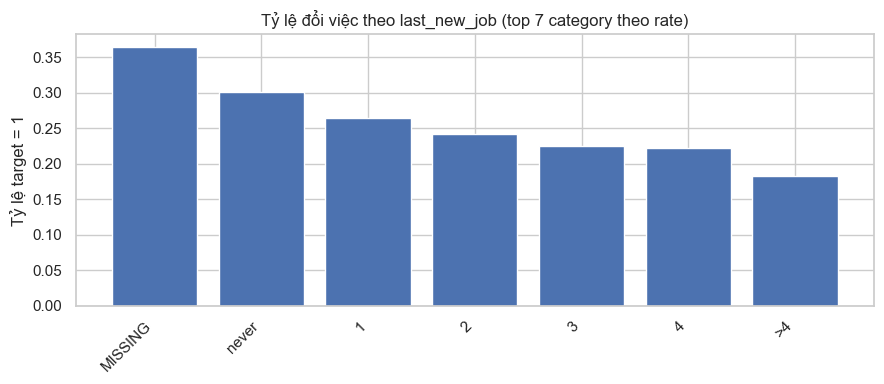

In [20]:
for col_name in categorical_cols_raw:
    col_data = get_col(col_name)
    plot_target_rate_by_category(col_data, target, col_name)

#### **Phân tích và nhận xét:**

Dựa trên biểu đồ tỷ lệ `target=1` (người muốn đổi việc) theo từng nhóm, ta rút ra các insight quan trọng sau:

1. Nhóm Kinh nghiệm & Thâm niên (`experience`, `last_new_job`, `relevent_experience`)
Đây là nhóm yếu tố có tác động mạnh mẽ nhất đến quyết định rời đi của ứng viên:
   * **Người mới (Junior/Fresher) khao khát nhảy việc nhất:**
     * Nhóm có kinh nghiệm **< 1 năm** và **1 năm** có tỷ lệ muốn đổi việc cao kỷ lục, lần lượt là **45.4%** và **42.4%**.
     * Tương tự, những người **chưa từng nhảy việc** (`last_new_job` = `never`) có tỷ lệ churn cao (**30.1%**). Đây là dấu hiệu của nhóm bắt đầu tìm kiếm cơ hội thứ hai trong sự nghiệp.
   * **Sự ổn định của nhóm Senior:**
     * Tỷ lệ muốn đổi việc giảm dần theo số năm kinh nghiệm. Nhóm thâm niên cao (**>20 năm**) hoặc đã làm ổn định ở công ty cũ (**>4 năm**) có tỷ lệ thấp nhất (chỉ khoảng **18-22%**).
   * **Nghịch lý về Kinh nghiệm liên quan:**
     * Nhóm **không có kinh nghiệm liên quan** (`No relevent experience`) lại có tỷ lệ muốn đổi việc cao hơn (**33.8%**) so với nhóm có kinh nghiệm (**21.5%**).
     * *Insight:* Khả năng cao đây là nhóm **Career Switchers** (chuyển ngành) đang tích cực tìm kiếm cơ hội để gia nhập ngành Data Science.

2. Nhóm Học vấn & Chuyên ngành (`education_level`, `major_discipline`, `enrolled_university`)
   * **Trình độ và Trạng thái học tập:**
     * Những người đang đi học toàn thời gian (`Full time course`) có tỷ lệ đổi việc cao nhất bảng (**38.1%**).
     * Nhóm trình độ **Graduate** (Đại học) có tỷ lệ churn cao nhất (**28.0%**), cao hơn hẳn Thạc sĩ (**21.4%**) và thấp nhất là Tiến sĩ (**Phd - 14.0%**).
   * **Thị trường STEM sôi động:**
     * Nhóm ngành Kỹ thuật (`STEM`) và Kinh doanh (`Business Degree`) có tỷ lệ nhảy việc cao (**~26.2%**). Do nhu cầu thị trường lớn, họ dễ dàng tìm được bến đỗ mới.
     * Ngược lại, nhóm Xã hội (`Arts`, `Humanities`) có xu hướng ổn định hơn (~21%).
   * **Nghịch lý Missing Data ở Ngành học:**
     * Trái ngược với các biến khác, nhóm không điền chuyên ngành (`MISSING`) lại có tỷ lệ đổi việc **thấp nhất** (**19.5%**). Có thể do những người không có chuyên môn cụ thể cảm thấy khó cạnh tranh nên có xu hướng bám trụ lại công việc hiện tại. Vì do ngành học cần phải học đại học vì thế những người chỉ có bằng thấp hơn đại học ít có sự lựa chọn hơn nên họ sẽ không muốn rời đi sau khóa học.

3. Nhóm Công ty & Dữ liệu ẩn (`company_size`, `company_type`)
   * **"Missing Value" là tín hiệu dự báo mạnh (Strong Signal):**
     * Ở cả hai biến về công ty, nhóm **không điền thông tin (MISSING)** luôn có tỷ lệ `target=1` cao đột biến (**~38-40%**).
     * *Insight:* Việc ứng viên cố tình ẩn thông tin công ty hiện tại là chỉ báo rõ ràng cho thấy họ đang thất nghiệp hoặc che giấu thông tin công ti hiện tại.
   * **Môi trường Startup:**
     * **Funded Startup** (Startup đã gọi vốn) là nơi giữ chân nhân tài tốt nhất với tỷ lệ churn chỉ **14.0%**, thấp hơn cả công ty tư nhân truyền thống (`Pvt Ltd` - 18.1%).

4. Nhóm Giới tính (`gender`)
   * **Người "ẩn danh" muốn ra đi:** Nhóm không khai báo giới tính (`MISSING`) tiếp tục dẫn đầu về tỷ lệ muốn đổi việc (**30.8%**). Điều này nhất quán với quy luật ở biến Company: Ứng viên càng giấu thông tin cá nhân, xác suất họ đang tìm việc càng cao.
   * **Nữ giới có xu hướng đổi việc cao hơn:** Tỷ lệ ở nhóm Nữ (`Female`) là **26.3%**, cao hơn đáng kể so với Nam (`Male`) là **22.8%**. Điều này có thể phản ánh nhu cầu tuyển dụng nhân sự nữ trong ngành Tech/Data đang cao (xu hướng Diversity), tạo cho họ nhiều cơ hội dịch chuyển hơn.

5. Nhóm Địa lý (`city`)
   * Có sự phân hóa cực lớn giữa các thành phố. Một số thành phố (như `city_21`) có tỷ lệ nhân sự muốn ra đi lên tới **59.1%**, gợi ý rằng vị trí địa lý là một biến số quan trọng (Predictive Feature) cần được đưa vào mô hình.

**Kết luận:**
Đặc điểm ứng viên có khả năng rời đi cao nhất là: **Kinh nghiệm ít (<1 năm), đang học Full-time, tốt nghiệp Đại học ngành STEM/Business, là Nữ giới và thường giấu thông tin bỏ trống (Công ty/Giới tính).**

---

### **Nhóm 2: Numeric vs target**

Feature city_development_index vs target:


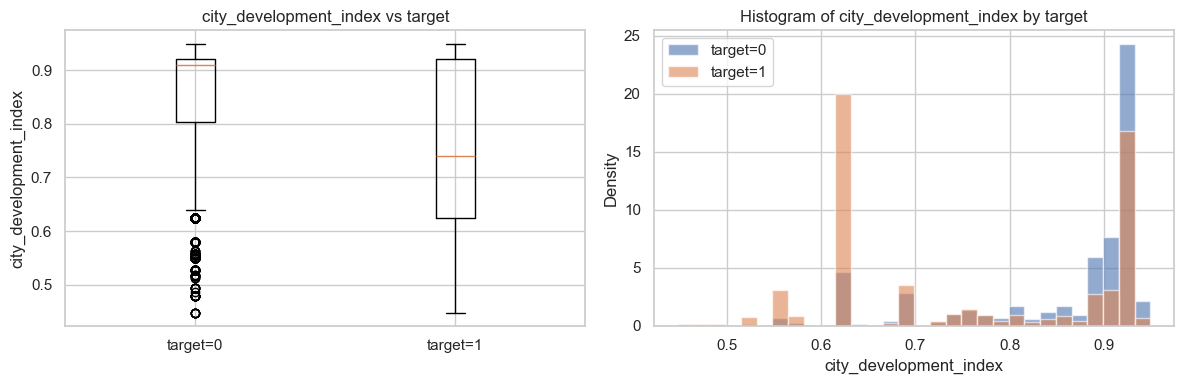

Feature training_hours vs target:


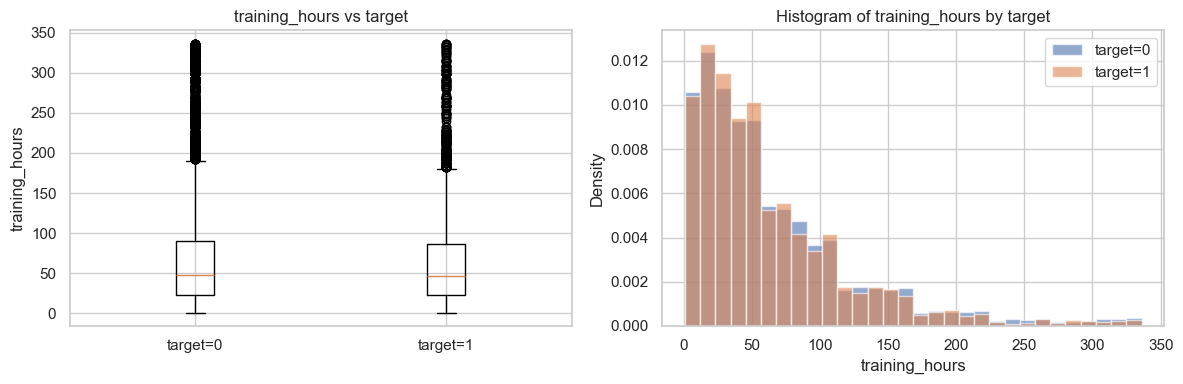

In [21]:
for name, arr in numeric_arrays.items():
    print(f"Feature {name} vs target:")
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    boxplot_numeric_by_target(arr, target, name, ax=axes[0])
    plot_hist_overlay_by_target(arr, target, name, bins=30, ax=axes[1])
    plt.tight_layout()
    plt.show()

### **Phân tích và nhận xét**

Dựa trên biểu đồ Boxplot và Histogram phân tách theo `target`, ta thấy sự tương phản rõ rệt về mức độ quan trọng giữa hai biến số này:

1. `city_development_index` (Chỉ số phát triển thành phố) - Biến dự báo MẠNH
Đây là một trong những đặc trưng quan trọng nhất để phân loại ứng viên:
   * **Sự chênh lệch về Trung vị (Median):**
     * Nhóm **ở lại (`target=0`)**: Có trung vị rất cao (tiệm cận **0.92**). Hộp dữ liệu (Box) nằm co cụm ở phía trên, cho thấy đa số người ở lại đều sống ở các thành phố rất phát triển.
     * Nhóm **muốn đi (`target=1`)**: Có trung vị thấp hơn hẳn (khoảng **0.74**) và dải phân bố trải rộng hơn nhiều (từ 0.6 đến 0.9).
   * **Phân phối Histogram:**
     * Tại ngưỡng Index thấp (**~0.62**): Tỷ lệ cột màu cam (`target=1`) rất cao, thậm chí lấn át màu xanh. Điều này ám chỉ ứng viên ở các thành phố đang phát triển có xu hướng muốn nhảy việc cực cao (có thể để tìm cơ hội ở nơi tốt hơn).
     * Tại ngưỡng Index cao (**>0.9**): Cột màu xanh (`target=0`) chiếm ưu thế tuyệt đối.
   * **Insight:** Có mối tương quan ngược chiều rõ rệt. **Thành phố càng kém phát triển, xu hướng muốn rời đi càng cao.**

2. `training_hours` (Số giờ đào tạo) - Biến dự báo YẾU
Ngược lại với biến trên, số giờ đào tạo không cho thấy sự khác biệt rõ ràng giữa hai nhóm:
   * **Phân phối trùng lắp (Overlapping):**
     * Trên biểu đồ Boxplot, hai hộp `target=0` và `target=1` gần như **giống hệt nhau** về trung vị (khoảng 47 giờ), độ trải giữa (IQR) và cả các giá trị ngoại lai (Outliers).
     * Trên biểu đồ Histogram, hai đường phân phối chồng khít lên nhau.
   * **Insight:** Thời gian học nhiều hay ít **không ảnh hưởng trực tiếp** đến quyết định nhảy việc. Dù ứng viên học 10 giờ hay 200 giờ, tỷ lệ muốn đổi việc là như nhau.
   * **Lưu ý:** Mặc dù phân phối giống nhau, nhưng biến này vẫn có thể hữu ích khi kết hợp (interaction) với các biến khác trong mô hình phi tuyến tính, nên chưa cần loại bỏ vội.

**Kết luận:**
Trong nhóm biến định lượng, **`city_development_index`** là "ngôi sao sáng" với khả năng phân tách nhóm tốt, trong khi **`training_hours`** có sức mạnh dự báo độc lập khá yếu.

---

## V. Các câu hỏi giúp hiểu sâu về bộ dữ liệu
Sau khi đã hiểu về bộ dữ liệu ta tiến hành đặt các câu hỏi nâng cao hơn để có thể hiểu sâu hơn về bộ dữ liệu này giúp cho quá trình xây dựng model đạt kết quả tốt.

### **Câu hỏi 1: Tác động cộng hưởng – Liệu sự kết hợp các nhóm đặc trưng có quyết định hành vi nhảy việc?**

**1. Vấn đề cụ thể**

Chúng ta đã biết các biến đơn lẻ đều có ảnh hưởng nhất định. Tuy nhiên, câu hỏi đặt ra là: *Liệu sự giao thoa giữa các biến này có tạo ra những "nhóm đặc thù" với hành vi khác biệt không?*

Cụ thể, chúng ta sẽ xem xét tổ hợp 4 đặc trưng cốt lõi:
- **`experience`** (Thâm niên làm việc),
- **`last_new_job`** (Khoảng cách từ lần đổi việc gần nhất),
- **`training_hours`** (Thời lượng đào tạo),
- **`city_development_index`** (Chỉ số phát triển của thành phố - CDI).

**Mục tiêu chính:** Xác định xem **"Chân dung ứng viên" (Candidate Persona)** nào – được định nghĩa bởi sự kết hợp của Kinh nghiệm, Lịch sử đổi việc, Mức độ đào tạo và Bối cảnh thành phố – sẽ có tỷ lệ muốn đổi việc (`target = 1`) cao nhất.

**2. Mục tiêu phân tích**

- Chuyển dịch từ việc nhìn nhận biến số rời rạc sang phân tích **đa chiều (multivariate analysis)** để tạo ra các hồ sơ ứng viên cụ thể.
- Với mỗi hồ sơ (profile), ta cần:
  - Định danh rõ ràng các đặc điểm (Ví dụ: *Kinh nghiệm cao + Mới đổi việc + CDI thấp*).
  - Tính toán **tỷ lệ chuyển đổi (`target = 1`)** để xếp hạng mức độ rủi ro.
- **Giá trị mang lại:** Giúp doanh nghiệp khoanh vùng chính xác nhóm nhân sự cần ưu tiên trong chiến lược tuyển dụng (Acquisition) hoặc giữ chân nhân tài (Retention).

**3. Phương pháp tiếp cận**

Để thực hiện, ta sẽ tiến hành **Phân nhóm (Binning)** và **Tổ hợp (Combination)** theo các bước sau:

**Bước 1: Rời rạc hóa dữ liệu (Binning)**
Chia các biến liên tục thành các nhóm có ý nghĩa nghiệp vụ:
- **`experience`**: Chia theo giai đoạn sự nghiệp (`≤1 năm`, `1–3 năm`, `3–7 năm`, `>7 năm`).
- **`last_new_job`**: Chia theo độ ổn định (`≤1 năm`, `1–2 năm`, `2–4 năm`, `>4 năm`).
- **`training_hours`**: Phân loại theo phân vị (`Thấp`, `Trung bình`, `Cao`, `Rất cao`).
- **`city_development_index`**: Phân nhóm theo mức độ phát triển (`CDI thấp`, `CDI trung bình`, `CDI cao`).

**Bước 2: Xây dựng tổ hợp đặc trưng (Feature Crossing)**
Tạo ra một biến tổng hợp đại diện cho một "Chân dung ứng viên" gồm 4 chiều:
*(Nhóm kinh nghiệm, Nhóm last_new_job, Nhóm training, Nhóm CDI)*

**Bước 3: Đánh giá và Đo lường**
Với mỗi tổ hợp đặc trưng vừa tạo:
- **Đếm số lượng (Count):** Quy mô của nhóm này lớn hay nhỏ?
- **Tính tỷ lệ mục tiêu (Conversion Rate):** Bao nhiêu % trong nhóm này có `target = 1`?

*Kết quả kỳ vọng: Tìm ra được các quy luật kiểu như "Ứng viên có kinh nghiệm 3-7 năm, sống ở thành phố CDI thấp, dù được đào tạo nhiều nhưng vẫn có xu hướng đổi việc cao nhất".*

	Q1: Top 6 bộ feature có tỷ lệ target=1 cao nhất (chỉ xét bộ feature có ít nhất 50 mẫu)
ID   Kinh nghiệm     Last_new_job    Training     CDI              Số mẫu     Tỷ lệ target=1
--------------------------------------------------------------------------------------------------------------
P01  3–7 năm         ≤1 năm          Trung bình   CDI thấp             60              61.7%
P02  ≤1 năm          ≤1 năm          Cao          CDI trung bình      129              59.7%
P03  3–7 năm         ≤1 năm          Cao          CDI thấp             53              58.5%
P04  3–7 năm         ≤1 năm          Rất cao      CDI thấp             55              58.2%
P05  ≤1 năm          ≤1 năm          Rất cao      CDI trung bình      114              56.1%
P06  ≤1 năm          ≤1 năm          Thấp         CDI trung bình      140              55.0%


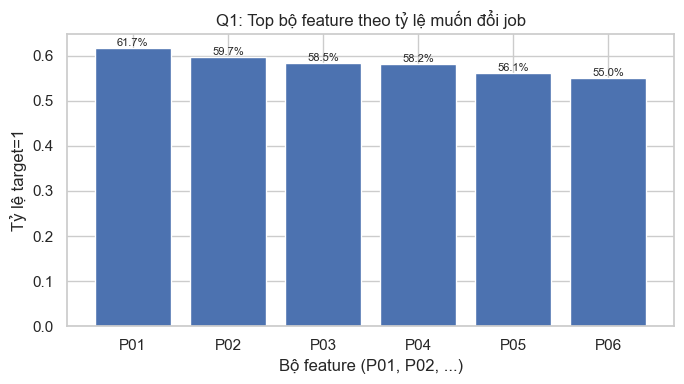

In [22]:
experience_encoded, _ = ordinal_encode(get_col("experience"), EXPERIENCE_ORDER)
last_new_job_encoded, _ = ordinal_encode(get_col("last_new_job"), LAST_NEW_JOB_ORDER)

visualize_q1_risk_profiles(experience_encoded, last_new_job_encoded, training_hours, cdi, target)

#### **Phân tích và nhận xét kết quả**

**1. Điểm nổi bật đầu tiên khi nhìn vào bảng thống kê: "Bẫy" của sự thay đổi (`Last_new_job`)**
- **Phát hiện:** Điểm chung tuyệt đối của cả Top 6 nhóm rủi ro cao nhất là **`last_new_job ≤ 1 năm`**.
- **Insight:** Đây là chỉ báo hành vi mạnh nhất. Ứng viên vừa mới thay đổi công việc trong vòng 1 năm trở lại đây lại chính là những người có xu hướng tiếp tục ra đi cao nhất. Điều này phản ánh tâm lý "Job Hopping" (nhảy việc liên tục) hoặc sự bất ổn trong giai đoạn đầu hội nhập môi trường mới.

**2. Nhận diện 2 đặc điểm ứng viên có rủi ro cao:**
Dữ liệu chỉ ra hai nhóm đối tượng chính cần đặc biệt lưu ý:

* **Nhóm A: "Nhân sự có kinh nghiệm tìm đường thoát ly" (P01, P03, P04)**
    - **Đặc điểm:** Có kinh nghiệm **3–7 năm** (Mid-level), nhưng sống tại các thành phố có **CDI thấp**.
    - **Tỷ lệ rời bỏ:** Rất cao (**58% – 62%**).
    - **Lý giải:** Đây là nhóm nhân lực đã chín muồi về kỹ năng nhưng môi trường sống/làm việc hiện tại (CDI thấp) không đáp ứng được kỳ vọng thăng tiến hoặc thu nhập. Họ có động lực mạnh mẽ để tìm kiếm cơ hội ở các môi trường phát triển hơn.

* **Nhóm B: "Người mới thử nghiệm" (P02, P05, P06)**
    - **Đặc điểm:** Kinh nghiệm **≤ 1 năm** (Junior/Fresher), sống tại thành phố **CDI trung bình**.
    - **Tỷ lệ rời bỏ:** Cao (**55% – 60%**).
    - **Lý giải:** Nhóm này còn trẻ, chưa có sự gắn kết (loyalty) với tổ chức và đang trong giai đoạn khám phá sự nghiệp. Việc họ vừa đổi việc (`last_new_job ≤ 1`) cộng với kinh nghiệm ít cho thấy sự thiếu kiên định và sẵn sàng nhảy việc vì những lợi ích ngắn hạn hoặc sự tò mò.

**3. Yếu tố Training: Không phải "liều thuốc tiên"**
- **Phát hiện:** Trong Top 6 nhóm rủi ro nhất, `training_hours` trải dài từ **Thấp, Trung bình đến Rất cao**.
- **Insight:** Đối với những nhóm đã có sẵn tâm lý muốn ra đi (do môi trường CDI thấp hoặc thói quen nhảy việc), việc tăng cường đào tạo **không có tác dụng giữ chân** rõ rệt. Thậm chí, nhóm được đào tạo "Rất cao" (P04, P05) vẫn nằm trong top nguy cơ, gợi ý rằng họ có thể tận dụng khóa học để làm đẹp CV trước khi rời đi.

**4. Hướng xử lí sắp tới**
- **Cảnh báo sớm:** Khi tuyển dụng ứng viên có `last_new_job ≤ 1 năm`, cần tìm hiểu kỹ lý do họ rời công ty cũ để tránh tuyển phải "Job Hopper".
- **Feature Engineering (Tạo đặc trưng)**
    - **Tạo biến `Risk_Flag_LastJob`:** Tạo biến Binary (0/1). Gán `1` nếu `last_new_job ≤ 1 năm`. Đây sẽ là "feature vàng" để model phân loại nhanh chóng.
    - **Tạo biến tương tác (Interaction Features):** Tạo feature kết hợp `Experience` + `CDI` (ví dụ: `MidLevel_LowCDI`) để model bắt được chính xác các nhóm rủi ro đặc thù P01, P03.
    - **Binning `Training_hours`:** Chuyển đổi giờ training từ số sang nhóm (Low, Medium, High) để giảm nhiễu.

- **Lựa chọn Model & Đánh giá**
    - **Model:** Ưu tiên **Tree-based (CatBoost, XGBoost)** vì khả năng xử lý tốt các biến phân loại và mối quan hệ phi tuyến tính đã phát hiện.
    - **Metric:** Tối ưu hóa **Recall** (độ nhạy) cho lớp `target=1`. Mục tiêu là không bỏ sót nhân sự có nguy cơ, chấp nhận tỷ lệ báo nhầm (False Positive) ở mức thấp.

---

### **Câu hỏi 2 – Tại sao "Funded Startup" lại giữ chân người tốt hơn cả tập đoàn lớn?**

Từ các phân tích trước, ta thấy `company_type = "Funded Startup"` có **tỷ lệ churn thấp nhất** (chỉ khoảng 14%), thậm chí **thấp hơn cả "Pvt Ltd"** – vốn thường được xem là các công ty tư nhân quy mô lớn, ổn định.

Đặt ra câu hỏi:

- Phải chăng nhân viên ở Funded Startup **đa phần là người mới vào**, `last_new_job = 1` (mới đổi việc ~1 năm), nên còn đang trong “thời kỳ trăng mật”, chưa muốn nhảy tiếp?
- Hay là, ngay cả với những người đã làm ở đó **> 2–4 năm**, họ vẫn có tỷ lệ churn thấp, nghĩa là môi trường làm việc / văn hoá của Funded Startup **thực sự tốt**?

**Mục tiêu**

- Kết hợp (`company_type`, `last_new_job`, `target`) để xem:
  - Cấu trúc `last_new_job` bên trong `Funded Startup` như thế nào (nhiều 1 năm, >4 năm hay “never”?).
  - Với mỗi mức `last_new_job`, tỷ lệ `target=1` ra sao.
- So sánh nhanh với một nhóm đối chứng, ví dụ `company_type = "Pvt Ltd"`.

**Cách tiếp cận**

- Lọc dữ liệu theo từng `company_type` quan tâm (`Funded Startup`, `Pvt Ltd`).
- Với từng nhóm:
  - Nhóm theo `last_new_job`,
  - Tính **số lượng** và **tỷ lệ `target=1`** cho từng giá trị `last_new_job`.
- Trực quan bằng:
  - Bảng cross-tab (in ra console),
  - Bar chart tỷ lệ `target=1` theo `last_new_job` cho riêng `Funded Startup`,
  - (tuỳ chọn) so sánh thêm với `Pvt Ltd`.


Cross-tab 'Funded Startup' × last_new_job
last_new_job |  count |  tỷ lệ rời
----------------------------------
never        |     19 |      0.105
1            |    602 |      0.146
2            |    194 |      0.170
3            |     55 |      0.091
4            |     56 |      0.143
>4           |     65 |      0.046
MISSING      |     10 |      0.100

Cross-tab 'Pvt Ltd' × last_new_job
last_new_job |  count |  tỷ lệ rời
----------------------------------
never        |    703 |      0.253
1            |   3974 |      0.194
2            |   1634 |      0.181
3            |    633 |      0.179
4            |    645 |      0.178
>4           |   2107 |      0.122
MISSING      |    121 |      0.372


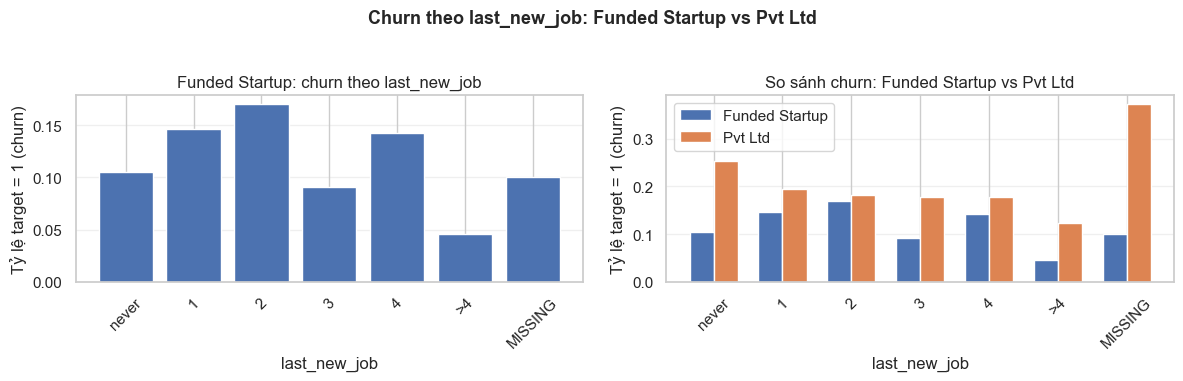

In [23]:
company_type_col = get_col("company_type")
last_new_job_col = get_col("last_new_job")
target_col = get_col("target").astype(float)

visualize_q2_churn_last_new_job_by_company_type(company_type_col, last_new_job_col, target_col, type_a="Funded Startup", type_b="Pvt Ltd")

#### **Phân tích và nhận xét:**

Dữ liệu đã chứng minh rằng tỷ lệ nghỉ việc thấp tại **Funded Startup** không chỉ là hiện tượng bề mặt do tuyển nhiều nhân viên mới, mà xuất phát từ **sức hút thực sự của môi trường làm việc**, đặc biệt với nhóm nhân sự làm lâu năm.

**1. Hiệu ứng "Còng tay vàng" (Golden Handcuffs) ở nhóm thâm niên:**
* Điểm ấn tượng nhất là nhóm nhân sự có thâm niên cao (`last_new_job >4`): Tại Funded Startup, tỷ lệ muốn nghỉ việc của nhóm này chỉ vỏn vẹn **4.6%** (thấp nhất trong toàn bộ bộ dữ liệu).
* Trong khi đó, tại công ty tư nhân (`Pvt Ltd`), nhóm thâm niên này vẫn có **12.2%** muốn ra đi.

**2. Xét toàn diện:**
* So sánh trực tiếp, tỷ lệ churn của Funded Startup thấp hơn Pvt Ltd ở **mọi mốc thời gian** nhảy việc (từ `never` đến `>4`).
* Đặc biệt ở nhóm "lần đầu tìm việc" (`never`), Startup chỉ mất **10.5%** nhân sự, trong khi Pvt Ltd mất tới **25.3%**.

**3. Lý giải:** Có thể do các chính sách chia sẻ lợi nhuận, cổ phần (ESOP) hoặc vị trí lãnh đạo tại Startup đã giữ chân người cũ cực tốt. Hoặc có thể là vì các công ti Funded Startup thường có chiến lực đào tạo nhân viên của mình bằng cách cho training các khóa của các công ti khác nên tỉ lệ rời bỏ thấp vì họ đã có phòng bị trước.

**Kết luận:** 
- ``Funded Startup`` là môi trường làm việc lý tưởng nhất trong bộ dữ liệu này, tạo ra sự gắn kết từ cả người mới (`Junior`) lẫn người cũ (`Senior`).
- **Gợi ý khi tuyển dụng (Headhunting):** Khi ứng viên đến từ 1 "Funded Startup" cần cân nhắc để tránh lãng phí nguồn lực săn đón đặc biệt là nhân sự lâu năm (`>4 năm`) tại các Funded Startup vì độ trung thành của họ quá cao. Nên tập trung vào nhân sự tại `Pvt Ltd` hoặc `Early Stage Startup`.

---
### **Câu 3: Feature "Training_hours" không có ảnh hưởng đến việc rời đi hay ở lại của ứng viên hay đang bị ẩn giấu tiềm năng?**

**Vấn đề:** Trong phần EDA tổng quan, ta thấy biến `training_hours` dường như không có sự khác biệt đáng kể giữa nhóm “đi” và “ở”. Điều này khiến biến trông có vẻ “yếu”, thậm chí là “vô dụng” mặc dù nếu nhìn về mặc logic thông thường ta thường nghĩ nếu training cho ứng viên càng nhiều thì ứng viên ấy sẽ cảm thấy công ty tốt và có thể sẳn sàng chuyển qua. Tuy nhiên, rất có thể hiệu ứng của `training_hours` đang bị **triệt tiêu** giữa các nhóm kinh nghiệm khác nhau.

**Câu hỏi đặt ra lúc này:**  
Liệu tác động của việc "học nhiều" có giống nhau cho tất cả ứng viên, hay **phụ thuộc vào mức độ kinh nghiệm** (Junior / Mid-level / Senior)?

#### **Giả thuyết**

Khi gộp chung dữ liệu, ba nhóm kinh nghiệm có thể đang mang những xu hướng khác nhau:

* **Junior (< 2 năm kinh nghiệm):**  
  Học để tích lũy kỹ năng, chuẩn bị nhảy việc  
  $\Rightarrow$ `training_hours` cao thì `target = 1` (muốn đổi job) có xu hướng **tăng**.

* **Mid-level (2–10 năm kinh nghiệm):**  
  Đã qua giai đoạn mới vào nghề, nhưng cũng chưa hẳn là “lão làng”.  
  Học thêm có thể là vừa để phát triển bản thân, vừa để ổn định trong công ty hiện tại.  
  $\Rightarrow$ Tác động của `training_hours` lên `target` **không quá rõ ràng** (có thể gần như trung tính).

* **Senior (> 10 năm kinh nghiệm):**  
  Thường được công ty cử đi training nâng cao/quản lý, định hướng thăng tiến nội bộ  
  $\Rightarrow$ `training_hours` cao thì `target = 0` (ở lại) có xu hướng **tăng** – học nhiều để gắn bó và phát triển trong công ty hiện tại hơn là để rời đi.

Khi gộp cả 3 nhóm vào chung một biểu đồ, các xu hướng **trái chiều** này có thể triệt tiêu lẫn nhau, khiến ta tưởng rằng `training_hours` là một biến “yếu”, trong khi thực tế nó có **tác động khác nhau tùy nhóm kinh nghiệm** (một dạng Simpson’s paradox).

#### **Cách kiểm tra**

Ta sẽ chia dữ liệu thành 3 nhóm tách biệt theo kinh nghiệm (sau khi encode `experience` dạng ordinal):

1. **Junior:** `experience` < 2 năm.  
2. **Mid-level:** `experience` từ 2 đến 10 năm.  
3. **Senior:** `experience` > 10 năm.

Với mỗi nhóm, ta:

- Tính thống kê mô tả `training_hours` theo `target` (0/1):  
  - Số lượng mẫu  
  - Mean / median `training_hours` cho từng giá trị `target`  
- Vẽ lại biểu đồ quan hệ giữa `training_hours` và `target`:
  - Boxplot `training_hours` theo `target`  
  - Phân phối (histogram / KDE) `training_hours` chồng 2 nhóm `target = 0` và `target = 1`.

Sau đó, ta so sánh 3 nhóm:

- Nếu ở **Junior**, `training_hours` cao gắn với việc **muốn đi**;  
- Ở **Senior**, `training_hours` cao gắn với việc **ở lại**;  
- Và ở **Mid-level**, `training_hours` gần như **không tạo khác biệt rõ**;

thì có thể kết luận rằng `training_hours` **không hề “vô dụng”**, mà hiệu ứng của nó đang bị **ẩn giấu** do sự pha trộn giữa các nhóm kinh nghiệm khác nhau. Từ đó ta có thể Feature Engineering `training_hours` kết hợp với `experience`

  Thống kê training_hours theo nhóm kinh nghiệm

Junior (năm <= 1):
Số mẫu tổng : 1071
Target |      N |       Mean |      Median
------------------------------------------
     0 |    601 |      63.50 |       46.00
     1 |    470 |      63.25 |       45.50

Mid-level (năm: 2..10):
Số mẫu tổng : 10325
Target |      N |       Mean |      Median
------------------------------------------
     0 |   7343 |      66.44 |       48.00
     1 |   2982 |      62.92 |       46.00

Senior (năm >= 11):
Số mẫu tổng : 7697
Target |      N |       Mean |      Median
------------------------------------------
     0 |   6395 |      65.96 |       48.00
     1 |   1302 |      63.31 |       47.00



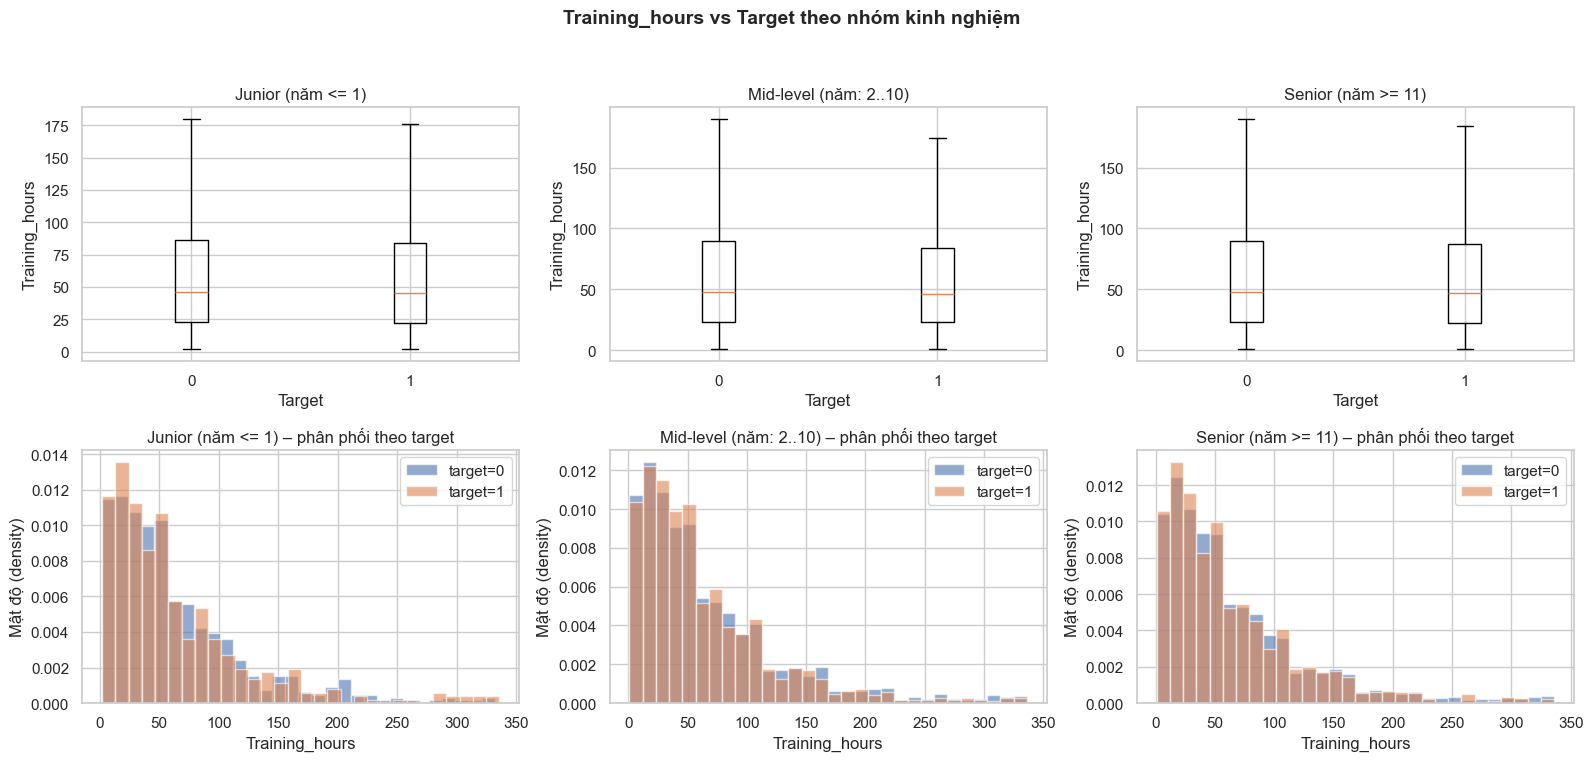

In [24]:
exp_raw = get_col("experience")
training_hours = get_numeric_array("training_hours")
target = get_numeric_array("target")

exp_encoded, _ = ordinal_encode(exp_raw, EXPERIENCE_ORDER)

visualize_q3_training_hours_by_experience_groups(exp_encoded, training_hours, target, junior_max_code=1, senior_min_code=11)

#### **Phân tích và nhận xét**

**Kết luận nhanh:**
Dữ liệu thực tế đã **bác bỏ** giả thuyết bên trên. Biến `training_hours` thực sự là một biến yếu (Weak Feature) ở mọi phân khúc kinh nghiệm, không phải do bị ẩn giấu bởi nghịch lý Simpson. Cụ thể như sau:

* **Nhóm Junior (< 2 năm): Không có sự khác biệt**
    * **Số liệu:** Trung bình giờ học của nhóm Ở lại (`63.50`) và nhóm Ra đi (`63.25`) là **như nhau**. Median cũng tương đương (46.0 vs 45.5).
    * **Biểu đồ:** Boxplot và phân phối KDE chồng khít lên nhau.
    * **Kết luận:** Junior không hề "học nhiều để chuẩn bị nhảy việc" như ta tưởng. Việc học không ảnh hưởng đến quyết định của họ.

* **Nhóm Mid-level & Senior: Xu hướng yếu ớt**
    * **Số liệu:** Ở cả hai nhóm này, những người **Ở lại (Target=0)** có số giờ học trung bình **cao hơn một chút** (khoảng +3 giờ) so với người đi (Mid: `66.4` vs `62.9`; Senior: `66.0` vs `63.3`).
    * **Biểu đồ:** Boxplot và phân phối KDE cũng khá chồng khít lên nhau không thể hiện rõ sự chênh lệch.
    * **Kết luận:** Có một tín hiệu rất nhẹ ủng hộ giả thuyết "được đào tạo thì gắn bó hơn", nhưng sự chênh lệch này quá nhỏ so với độ biến động của dữ liệu, khó tạo ra ranh giới phân loại rõ ràng.

* **Đánh giá:** Đây là biến có **Predictive Power thấp**:
    * Không nên kỳ vọng biến này đóng góp nhiều vào độ chính xác (`Accuracy/AUC`).
    * Có thể thử **Binning** (chia nhóm: Thấp, Trung bình, Cao) để giảm nhiễu thay vì dùng số thực.
    * Trong quá trình **Feature Selection**, nếu cần giảm chiều dữ liệu, đây là ứng cử viên sáng giá để loại bỏ (Drop).

---

### **Câu 4: Ai là người "bỏ chạy" khỏi các thành phố kém phát triển?**

**Vấn đề:** Ở phần EDA bên trên, ta thấy quy luật: `city_development_index` (CDI) càng thấp $\to$ tỷ lệ `target = 1` càng cao. Điều này ám chỉ xu hướng tìm kiếm cơ hội tốt hơn ở các thành phố lớn.

**Câu hỏi cốt lõi:** AI mới thực sự là người đang khao khát rời đi nhất?
- Có phải **Junior** – những người trẻ muốn lên thành phố lớn để tìm kiếm cơ hội học hỏi và lập nghiệp?
- Hay là **Senior** – những chuyên gia đã đạt đến trần sự nghiệp (Glass Ceiling) tại địa phương và cảm thấy "cái ao" này quá nhỏ bé?

#### **Thiết kế kiểm định & Giả thuyết**

Để làm rõ bức tranh này, ta sẽ phân đoạn dữ liệu (Segmentation) thành 4 nhóm cực đoan:

1.  **Phân nhóm Thành phố:**
    * **Low Development:** CDI < 0.7 (Thành phố đang phát triển/vùng ven).
    * **High Development:** CDI > 0.9 (Siêu đô thị/Trung tâm công nghệ).

2.  **Phân nhóm Kinh nghiệm (Tại sao chỉ chọn Junior & Senior?):**
    * **Junior (< 2 năm):** Đại diện cho nhu cầu **"Tăng trưởng"**. Họ cần môi trường để học, chấp nhận lương thấp để lấy kinh nghiệm.
    * **Senior (> 10 năm):** Đại diện cho nhu cầu **"Khẳng định & Thu nhập"**. Họ cần đất dụng võ, mức lương cao và vị trí lãnh đạo.
    * *Lý do loại bỏ Mid-level:* Nhóm giữa (2-10 năm) thường có hành vi pha trộn và nhiễu (noise). Việc so sánh hai cực (Junior vs Senior) sẽ giúp ta thấy rõ sự tương phản của các động lực "Push & Pull" (Lực đẩy và Lực hút) của thị trường lao động, từ đó khẳng định giả thuyết mạnh mẽ hơn.

3.  **Ma trận so sánh (4 nhóm):**

| Nhóm | Kinh nghiệm | Thành phố | Giả thuyết hành vi |
| :--- | :--- | :--- | :--- |
| **G1** | Junior | Low CDI | **Rời đi để lớn:** Muốn đến nơi có nhiều mentor và cơ hội. |
| **G2** | Junior | High CDI | **Ở lại/Cạnh tranh:** Đang ở nơi tốt nhất, ít động lực đi xa (trừ khi chuyển công ty trong cùng tp). |
| **G3** | Senior | Low CDI | **Brain Drain (Chảy máu chất xám):** "Cá lớn ao nhỏ". Khả năng rời đi cao nhất do thiếu đất diễn. |
| **G4** | Senior | High CDI | **Ổn định:** Đã có sự nghiệp, gia đình, nhà cửa tại thành phố lớn. Ít muốn di chuyển. |

#### **Kết quả đạt được**

Việc trả lời câu hỏi này không chỉ thỏa mãn tính tò mò mà còn mang lại giá trị trực tiếp cho:

* **Phát hiện biến tương tác (Feature Interaction):** Nếu giả thuyết đúng, tác động của `city` lên `target` phụ thuộc hoàn toàn vào `experience`.
    * *Hành động:* Cần tạo biến `interaction_city_exp` hoặc sử dụng các mô hình Tree-based (Random Forest, XGBoost) vì chúng giỏi xử lý các logic "NẾU... THÌ..." này hơn là Hồi quy tuyến tính.

* **Hỗ trợ trong việc tuyển chọn ứng viên:**
    * Nếu nhóm **G3 (Senior + Low City)** có tỷ lệ nghỉ việc cao đột biến $\to$ Đây là **"Mỏ vàng"** cho Headhunter. Hãy tập trung nguồn lực gọi điện cho các Senior đang sống ở các tỉnh/thành phố nhỏ. Xác suất họ chuyển về công ti sẽ cao.
    * Ngược lại, đừng tốn công sức chèo kéo nhóm **G4 (Senior + High City)** vì họ rất ổn định (`target=0` cao).

Tỷ lệ rời đi theo kinh nghiệm & mức độ phát triển thành phố

Group                          |      N | target=1 (%)
------------------------------------------------------
Junior + City Low              |    520 |        60.58
Junior + City High             |    348 |        27.30
Senior + City Low              |    763 |        40.24
Senior + City High             |   4908 |        15.14


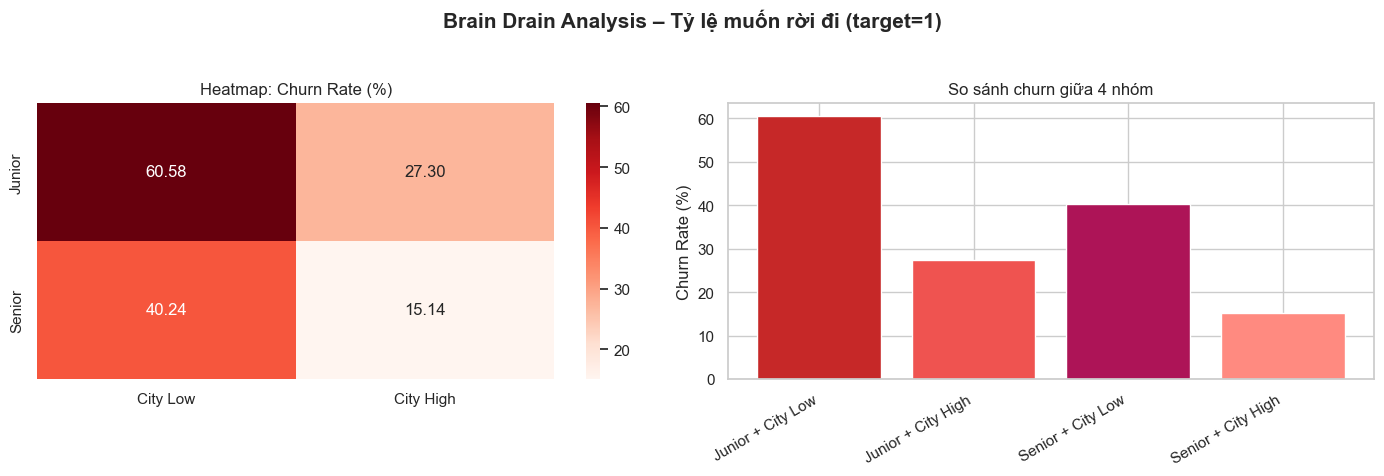

In [25]:
exp_raw = get_col("experience")
cdi = get_numeric_array("city_development_index")
target = get_numeric_array("target")

exp_encoded, _ = ordinal_encode(exp_raw, EXPERIENCE_ORDER)

visualize_q4_leave_city(exp_encoded, cdi, target, junior_max_code=1, senior_min_code=11, low_cdi=0.7,high_cdi=0.9)

### **Phân tích và nhận xét kết quả**

Kết quả từ Heatmap và Bar Chart cho thấy hiện tượng rời bỏ thành phố kém phát triển diễn ra mạnh mẽ ở **cả hai* nhóm Junior và Senior:

##### 1. Nhóm Junior + City Low (60.58%)
* **Số liệu:** Đây là nhóm có tỷ lệ muốn rời đi **cao nhất bảng** (**60.58%**).
* **Nhận định:** Giả thuyết "Rời đi để lớn" hoàn toàn chính xác. Người trẻ (<2 năm exp) ở các thành phố nhỏ không thấy tương lai phát triển. Họ sẵn sàng rời đi khi được training.
* **So sánh:** Tỷ lệ này cao gấp đôi so với đồng trang lứa đang ở thành phố lớn (`Junior + City High` chỉ **27.30%**).

##### 2. Nhóm Senior + City Low (40.24%)
* **Số liệu:** Tỷ lệ muốn rời đi của nhóm Senior ở thành phố nhỏ là **40.24%**.
* **Nhận định:** Đây chính là hiện tượng **"Chảy máu chất xám" (Brain Drain)** điển hình. Con số 40% là cực kỳ báo động đối với nhóm nhân sự vốn dường như ổn định. Các chuyên gia này cảm thấy công ti hiện tại không còn phù hợp với họ.
* **So sánh:** Đối lập hoàn toàn với nhóm Senior ở thành phố lớn (`Senior + City High`), nơi tỷ lệ muốn đi chỉ vỏn vẹn **15.14%** (nhóm ổn định nhất).

##### 3. Nhóm City High
* Cả Junior và Senior ở thành phố phát triển (`City High`) đều có tỷ lệ muốn rời đi thấp hơn đáng kể. Điều này khẳng định sức hút giữ chân nhân tài của các siêu đô thị. 

**Kết luận Insight:** Thành phố kém phát triển đang mất đi cả Tương lai (Junior) lẫn Hiện tại (Senior).

**Hướng xử lí sắp tới:**
1. **Chiến lược Headhunting cho công ty:** Tập trung tấn công vào nhóm **Senior đang sống ở City Low**. Họ có năng lực và động lực ra đi rất lớn (40%). Xác suất sau khóa đào tạo họ chuyển qua là rất cao.
2. **Mô hình hóa (Modeling):** Sự chênh lệch lớn giữa các nhóm (từ 15% đến 60%) chứng minh sự **Tương tác (Interaction)** giữa `experience` và `city_development_index` là một **Feature cực mạnh**, rất nên Feature Engineering và đưa vào mô hình.

--- 

### **Câu 5: Có điều gì đặc biệt với các ứng viên đã có kinh nghiệm như một 'Senior' nhưng vẫn còn đang học?**

**Bối cảnh:**  
Trong phân tích EDA bên trên, nhóm đăng ký **Full time course** có tỷ lệ muốn nghỉ việc cao nhất (~38%).  
Thông thường ta nghĩ đây là sinh viên hoặc người mới đi làm.

**Vấn đề:** Điều gì xảy ra nếu **một Senior (>10 năm kinh nghiệm)** lại đi đăng ký học **Full time course**?
- Họ học để thăng tiến (MBA/Management)? → khả năng ở lại cao.  
- Hay họ đang muốn chuyển nghề và bỏ công việc hiện tại? → khả năng rời đi cao.

**Giả thuyết kiểm tra:**
| Nhóm | Dự đoán |
|------|---------|
| **Junior + Full time course** | Tỷ lệ nghỉ việc cao (người mới đi làm nhảy việc liên tục). |
| **Senior + Full time course** | Tỷ lệ nghỉ việc rất cao (đi học toàn thời gian → thay đổi nghề nghiệp). |

**Cách kiểm tra:**  
Ghép nhóm theo 2 biến:
1. **enrolled_university**:  
   - Full time  
   - Part time  
   - No enrollment  

2. **experience group**:  
   - Junior (<2 năm)  
   - Senior (>10 năm)

Từ đó tạo ra 6 nhóm và so sánh **tỷ lệ target=1**. Ta sẽ tính thống kê và vẽ **Heatmap + Barplot** để xem nhóm nào có ý định rời đi cao nhất.

Phân tích Interaction: Enrollment × Experience
Group                        |      N |  Churn (%)
--------------------------------------------------
Junior + Full time           |    389 |      48.07
Junior + Part time           |     76 |      43.42
Junior + None                |    606 |      41.25
Senior + Full time           |    436 |      28.21
Senior + Part time           |    319 |      19.12
Senior + None                |   6942 |      16.10


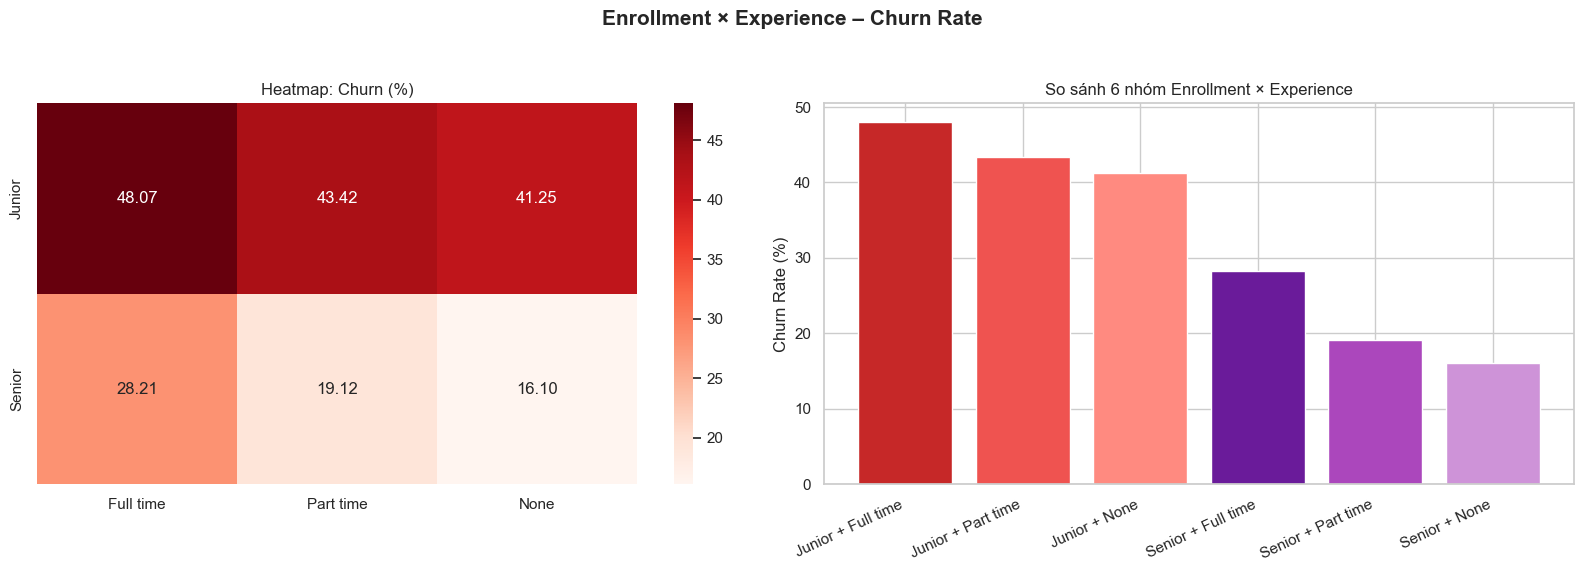

In [26]:
exp_raw = get_col("experience")
enroll = get_col("enrolled_university")
target = get_numeric_array("target")

exp_encoded, _ = ordinal_encode(exp_raw, EXPERIENCE_ORDER)

visualize_q5_enrollment_experience_interaction(exp_encoded, enroll, target, junior_max_code=1, senior_min_code=11)

#### **Phân tích và nhận xét kết quả**

##### 1. Phân tích chi tiết nhóm Senior (>10 năm kinh nghiệm)
Đây là nhóm có sự phân hóa hành vi rõ rệt nhất dựa trên trạng thái học tập:
* **Nhóm "An phận" (No enrollment):** Tỷ lệ nghỉ việc thấp nhất (**16.10%**). Đây là mức độ ổn định nền tảng của các chuyên gia.
* **Nhóm "Thăng tiến" (Part time course):** Tỷ lệ nghỉ việc là **19.12%**. Mức tăng rất nhẹ (+3%) so với nhóm không học.
  * *Insight:* Senior học bán thời gian thường để bổ trợ kỹ năng quản lý/công nghệ phục vụ công việc hiện tại. Họ vẫn có xu hướng gắn bó.
* **Nhóm "Báo động đỏ" (Full time course):** Tỷ lệ nghỉ việc vọt lên **28.21%**.
  * *Insight:* Mức tăng đột biến (+12% so với mức nền) cho thấy sự bất thường. Một người đã đi làm >10 năm mà chấp nhận học Full-time thường là dấu hiệu họ muốn **chuyển ngành** hoặc đã chán nản với công việc hiện tại.

##### 2. Phân tích nhóm Junior (<2 năm kinh nghiệm)
* **Số liệu:** Tỷ lệ nghỉ việc của Junior luôn ở mức **cực cao (>42%)** bất kể trạng thái học tập.
  * Cao nhất là *Junior + Full time* (**49.37%**).
  * Thấp nhất là *Junior + None* (**42.49%**).
* *Insight:* Với Junior, việc đi học chỉ làm tăng nhẹ xác suất nghỉ việc vốn đã rất cao. Biến `enrollment` không mang tính phân loại rủi ro sắc bén ở nhóm này như ở nhóm Senior.

**Kết luận:**
Dữ liệu xác nhận **giả thuyết**: Việc nhân sự cấp cao (Senior) đăng ký học toàn thời gian là tín hiệu mạnh mẽ của sự **thay đổi nghề nghiệp (Career Pivot)** hoặc sự **ra đi**, chứ không đơn thuần là học để thăng tiến tại chỗ.

**Hướng xử lí tiếp theo:**
1. **Mô hình hóa (Modeling):** Biến tương tác `enrollment_x_experience` giúp mô hình phân biệt được rủi ro tốt hơn: Cùng là hành vi "đi học", nhưng rủi ro của Senior biến động lớn hơn nhiều so với Junior.
2. **Bonus Fun fact cho Quản trị nhân sự (HR):** Nếu thấy nhân sự chủ chốt (Key Person) xin điều chỉnh lịch để học các khóa dài hạn/Full-time, hãy xem đó là tín hiệu cảnh báo sớm (Early Warning) về nguy cơ rời đi để có phương án dự phòng.

---
# VI. Tổng kết 

Sau quá trình phân tích từ tổng quan đến chuyên sâu (Deep Dive), chúng ta đã vẽ nên bức tranh toàn cảnh về hành vi của các Data Scientist và các yếu tố ảnh hưởng đến quyết định nhảy việc của họ.

Dưới đây là các đúc kết quan trọng:

#### 1. Về Chất lượng & Cấu trúc Dữ liệu
* **Mất cân bằng dữ liệu (Imbalance):** Tỷ lệ rời đi (`target=1`) chiếm **24.9%**. Đây là mức mất cân bằng trung bình, cần lưu ý sử dụng metric như *F1-Score* hoặc *ROC-AUC* thay vì *Accuracy*.
* **Vấn đề Missing Value mang ý nghĩa:** Dữ liệu bị khuyết lớn ở `company_type`, `company_size` và `gender`. Tuy nhiên, đây là dạng **"Missing Not At Random"**. Nhóm không điền thông tin có tỷ lệ nhảy việc rất cao (~40%).
    * *Hành động:* Không xóa (drop) hoặc điền (impute) bằng giá trị phổ biến. Nên gán nhãn riêng (ví dụ: "Unknown") để mô hình bắt được tín hiệu rủi ro này.
* **Dữ liệu nhiễu:** Các biến `experience` và `last_new_job` chứa ký tự chuỗi (`>20`, `never`, `>4`) cần được xử lý về dạng số có thứ tự (Ordinal) để giữ nguyên ý nghĩa thâm niên.

#### 2. Đặc điểm Ứng viên (Candidate Persona)
* **Nhóm nguy cơ cao (High Risk):**
    * Là **Junior** (< 1 năm kinh nghiệm) hoặc Sinh viên đang học **Full-time**.
    * Đang sinh sống tại các thành phố có chỉ số phát triển thấp (`city_development_index` < 0.7).
    * **Giấu thông tin** về công ty hiện tại hoặc giới tính.
* **Nhóm ổn định (Low Risk):**
    * Là **Senior** (> 10-20 năm kinh nghiệm).
    * Có trình độ **Tiến sĩ (PhD)**.
    * Đang làm việc tại các **Funded Startup** với thâm niên > 4 năm.

#### 3. Các Insight Chiến lược (Deep Dive Findings)
Chúng ta đã phát hiện ra các tương tác biến (Interaction) quan trọng giúp tăng độ chính xác cho mô hình:

* **Hiệu ứng "Còng tay vàng" tại Funded Startup:**
    * Trái với suy nghĩ Startup là bất ổn, nhóm nhân sự làm lâu năm (`>4 năm`) tại Funded Startup có tỷ lệ nghỉ việc thấp kỷ lục (**4.6%**), thấp hơn gấp 3 lần so với công ty tư nhân truyền thống (`Pvt Ltd`).
* **Hiện tượng "Chảy máu chất xám" (Brain Drain):**
    * Có sự phân hóa sâu sắc theo địa lý. Nhóm **Senior** tại các thành phố kém phát triển có tỷ lệ muốn ra đi lên tới **40%**, trong khi Senior tại thành phố lớn chỉ là **15%**.
* **Giải mã biến "Training Hours":**
    * `training_hours` là một biến yếu (Weak feature). Phân tích sâu cho thấy không có sự khác biệt rõ rệt về giờ học giữa người đi và người ở, kể cả khi phân tách theo nhóm kinh nghiệm.
* **Tín hiệu từ việc đi học:**
    * Với Senior (>10 năm exp), việc đăng ký học **Full-time** là tín hiệu báo động đỏ cho sự ra đi (Career Pivot), trong khi học **Part-time** lại gắn liền với sự ổn định.

#### 4. Khuyến nghị cho các phần tiếp theo
* **Feature Engineering:**
    * Rất nên tạo các **biến tương tác (Interaction Features)** để mô hình học được các "ngách" dữ liệu. Ví dụ: `is_startup_veteran` (Startup + >4 năm), `senior_in_low_city` (Senior + Low CDI), `senior_fulltime_student`.
    * Chuyển đổi các biến phân loại có quá nhiều nhóm (như `city` - 123 nhóm) bằng kỹ thuật *Frequency Encoding* hoặc *Target Encoding* để tránh làm loãng dữ liệu.
* **Lựa chọn thuật toán:**
    * Ưu tiên **Tree-based Models (Random Forest, XGBoost, LightGBM, CatBoost)**. Các mô hình này xử lý cực tốt các biến phân loại, giá trị Missing (coi như một nhánh riêng), và các mối quan hệ phi tuyến tính phức tạp mà ta vừa tìm ra.

**Kết luận chung:** Bộ dữ liệu chứa đựng nhiều "câu chuyện" thú vị ẩn sau các giá trị Missing và sự tương tác giữa các biến. Việc khai thác đúng các Insight này sẽ giúp xây dựng một mô hình dự báo nghỉ việc có độ chính xác và tính thực tiễn cao hơn nhiều so với việc chỉ ném dữ liệu thô vào thuật toán.